In [1]:
import pickle
import math
import pandas as pd
import numpy as np
np.random.seed(42) 
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from collections import defaultdict, Counter
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 50)

# Model imports
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
with open('final_df.pickle','rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,ELEVATION,precip_num_days_over_0.01,precip_num_days_over_0.1,precip_num_days_over_1,snow_depth_num_days_over_1,snowfall_num_days_over_1,max_temp_num_days_under_0,min_temp_num_days_under_32,max_temp_num_days_under_32,max_temp_num_days_over_70,max_temp_num_days_over_90,min_temp_year,max_snow_depth_year,max_snowfall_year,max_precip_day,max_temp_year,first_min_temp_under_32,first_min_temp_under_28,first_min_temp_under_24,first_min_temp_under_20,first_min_temp_under_16,last_min_temp_under_32,last_min_temp_under_28,last_min_temp_under_24,last_min_temp_under_20,last_min_temp_under_16,total_precip_year,total_snowfall_year,avg_daily_temp_year,avg_daily_max_temp,avg_daily_min_temp,high_incidence
0,100.300000,120.000000,62.000000,14.0,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,102.100000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1141.700000,35.05744,17.552706,23.943332,11.181082,0
1,107.300000,91.000000,74.000000,20.0,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,84.800000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1590.100000,35.05744,17.552706,23.943332,11.181082,0
2,103.800000,106.000000,74.500000,16.5,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,96.500000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1342.300000,35.05744,17.552706,23.943332,11.181082,0
3,31.723077,111.090909,75.909091,21.0,0.000000,0.000000,0.000000,47.200000,0.000000,253.000000,95.000000,-8.840000,0.000000,0.000000,91.172727,38.700000,-0.660000,-2.900000,-4.850000,-6.700000,-9.526784,-1.200000,-2.720000,-5.080000,-9.400000,-9.766667,1497.054545,0.00000,18.848000,24.846000,12.854000,0
4,29.991667,95.300000,64.500000,14.1,0.673203,0.476935,0.000000,21.666667,0.000000,280.000000,97.250000,-5.933333,22.512255,25.230208,95.080000,38.600000,-1.400000,-2.500000,-5.256631,-7.443868,-9.526784,-2.033333,-2.766667,-4.600000,-6.700000,-10.532082,1218.360000,35.05744,20.060000,26.047500,14.013333,0


## Detecting Class Imbalance
- There is a large class imbalance issue with this data
- I will experiment with undersampling and oversampling to see if they will improve model performance

In [4]:
# Observing Large Class Imbalance
df.high_incidence.value_counts()/len(df)

0    0.854723
1    0.145277
Name: high_incidence, dtype: float64

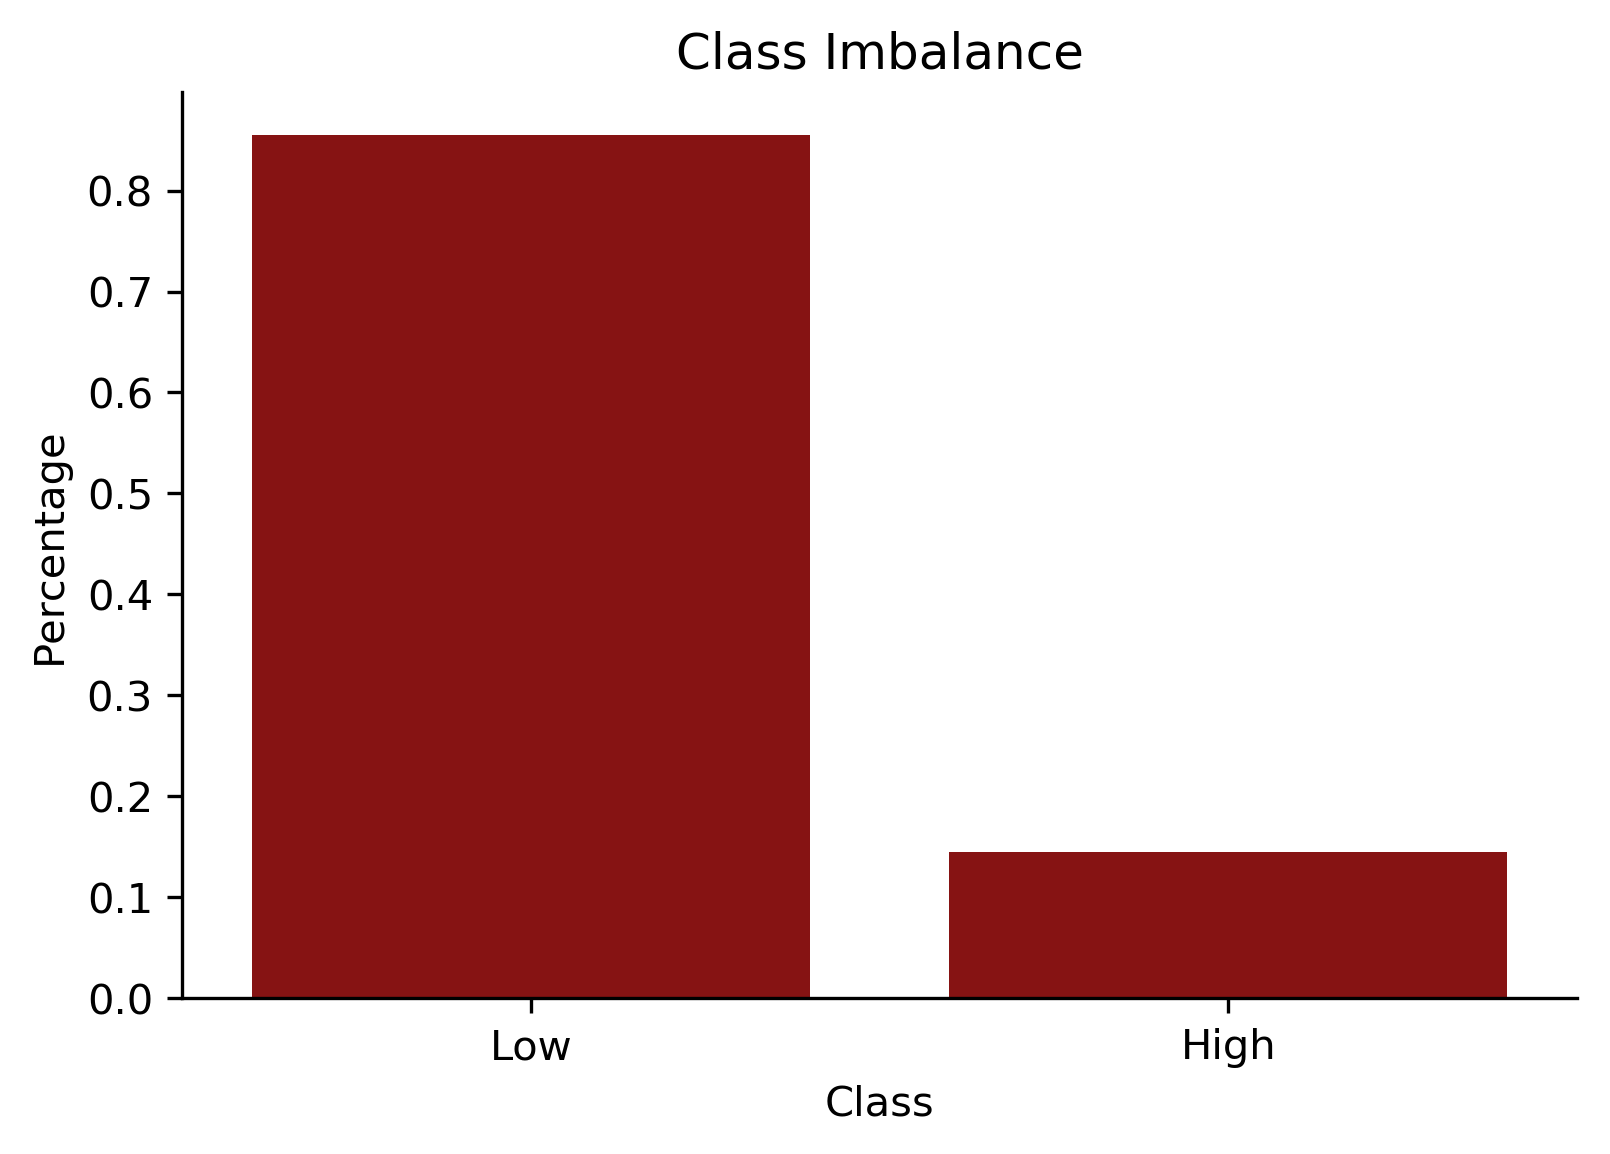

In [5]:
# Plotting Class Imbalance 
plt.figure(dpi=300)
sns.barplot(['Low', 'High'], df.high_incidence.value_counts()/ len(df), color='#990000ff')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Imbalance')

sns.despine()

## Train-Validation-Test Splits

In [6]:
# Splitting data into feature variables
X = df.iloc[:,:-1]
# and target variable
y = df.iloc[:,-1]

In [7]:
# Test-Validation-Train Split (60-20-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42,stratify=y_test)

In [8]:
# Verifying Correct Percentages
print('Training Set:',len(X_train)/len(X))
print('Validation Set:',len(X_val)/len(X))
print('Test Set:',len(X_test)/len(X))

Training Set: 0.5999895106728903
Validation Set: 0.19997902134578066
Test Set: 0.200031467981329


## Modeling

In [9]:
def complete_grid_search(X_train, y_train, steps_list, param_grid):
    ''' This function does a grid search with cross validation for
    every combination of hyperparameters and resampling techniques.
    
    Input:
    X_train = DataFrame of features in training split
    
    y_train = Series of target variable in training split
    
    steps_list = List of lists of Imblearn pipeline steps
                 Ex: [[('scaler', StandardScaler()),('LR', LogisticRegression())],
                      [('scaler', StandardScaler()), ('ros', RandomOverSampler()),
                       ('LR', LogisticRegression())]
                 
    param_grid = Dictionary of hyperparameters to grid search. Keys are labels for 
                 each hyperparameter and Values are ranges for each hyperparameter.
                 Ex: {'LR__C':[x for x in np.logspace(-3,3,7)], 'LR__penalty':['l1','l2']}
    Output:
    Returns a list of the best model for each set of pipeline steps in steps_list.
    '''
    
    grid_search_results = []
    for steps in steps_list:
        pipeline = Pipeline(steps)

        grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=10, scoring='roc_auc')

        grid.fit(X_train, y_train)
        
        print(grid.best_score_)
        print(grid.best_params_)

        grid_search_results.append(grid)

    return grid_search_results

In [10]:
def best_model_finder(grid_search_results, steps_list):
    ''' This function finds the best model out of all 
    the grid searches from the complete_grid_search function.
    
    Input:
    grid_search_results = Output of complete_grid_search function(list of models)
    
    steps_list = List of lists of Imblearn pipeline steps
                 Ex: [[('scaler', StandardScaler()),('LR', LogisticRegression())],
                      [('scaler', StandardScaler()), ('ros', RandomOverSampler()),
                       ('LR', LogisticRegression())]
                       
    Output:                   
    Returns the best model and prints the hyperparameters
    and resampling techniques for that best model.
    '''
    
    # Finds best scores for each grid search
    score_list = [x.best_score_ for x in grid_search_results]
    
    # finds best model out of all grid searches
    best_model_ix = score_list.index(max(score_list))
    best_model = grid_search_results[best_model_ix]

    print('Hyperparameters:',best_model.best_params_)
    print('Tranformations/Resampling:',steps_list[best_model_ix])
    
    return best_model

In [11]:
def roc_curve_calculator(model, X, y):
    ''' Calculates the roc curve for a given model and data inputs.
    
    Inputs:
    model = any kind of model
    X = features DataFrame
    y = target Series
    
    Output:
    Returns the false positive rate and true positive rate
    for all thresholds and the ROC AUC score.   
    '''
    # Determining model predictions
    y_predictions = [pred[1] for pred in model.predict_proba(X)]
    
    # Calculating fpr and tpr for all thresholds
    fpr, tpr, _ = metrics.roc_curve(y,y_predictions)
    
    # Finding ROC AUC Score
    roc_auc = metrics.roc_auc_score(y,y_predictions)
    print('ROC AUC Score on Unseen Data:',roc_auc)
          
    return fpr, tpr, roc_auc

### K-Nearest Neighbors

In [12]:
knn_steps_list = [[('scaler', StandardScaler()),('KNN', KNeighborsClassifier(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('ros', RandomOverSampler()),
                  ('KNN', KNeighborsClassifier(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('smote',SMOTE()),
                  ('KNN', KNeighborsClassifier(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('adasyn',ADASYN()),
                  ('KNN', KNeighborsClassifier(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('rus',RandomUnderSampler()),
                  ('KNN', KNeighborsClassifier(n_jobs=-1))]]

knn_parameters = {'KNN__n_neighbors':[x for x in range(1,30)]}

In [13]:
knn_grid_search_results = complete_grid_search(X_train, y_train, knn_steps_list, knn_parameters)

Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... KNN__n_neighbors=1, score=0.7723083512960813, total=   3.8s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.7858541056393816, total=   0.3s
[CV] KNN__n_neighbors=1 ..............................................
[CV] ...... KNN__n_neighbors=1, score=0.762972133934511, total=   0.1s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.7704572766770407, total=   0.1s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.7s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.7756856068776384, total=   0.4s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.2s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8350098564822491, total=   0.3s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.8s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8502390427237053, total=   0.2s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.4s remaining:    0.0s


[CV] ...... KNN__n_neighbors=2, score=0.840755660679528, total=   0.1s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.9s remaining:    0.0s


[CV] ...... KNN__n_neighbors=2, score=0.834549964564139, total=   0.1s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.4s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8470927187008905, total=   0.2s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8642568949317415, total=   0.3s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8781058666027991, total=   0.2s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8652986177840195, total=   0.2s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8753743875758789, total=   0.2s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8719263242227221, total=   0.2s
[CV] KNN__n_neighbors=4 ..............................................
[CV] ..... KNN__n_neighbors=4, score=0.8812808206979986, total=   0.2s
[CV] KNN__n_neighbors=4 ..............................................
[CV] .

[CV] .... KNN__n_neighbors=14, score=0.9233305923078818, total=   0.2s
[CV] KNN__n_neighbors=14 .............................................
[CV] .... KNN__n_neighbors=14, score=0.9155309216405263, total=   0.3s
[CV] KNN__n_neighbors=14 .............................................
[CV] .... KNN__n_neighbors=14, score=0.9097448618001418, total=   0.2s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9127770408445255, total=   0.2s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9195430092669357, total=   0.3s
[CV] KNN__n_neighbors=15 .............................................
[CV] ..... KNN__n_neighbors=15, score=0.922935607460517, total=   0.5s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9154554278495055, total=   0.6s
[CV] KNN__n_neighbors=15 .............................................
[CV] .

[CV] .... KNN__n_neighbors=26, score=0.9148703918642569, total=   0.2s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9269361385925804, total=   0.2s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9250175548821051, total=   0.2s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9146334699411456, total=   0.2s
[CV] KNN__n_neighbors=26 .............................................
[CV] ..... KNN__n_neighbors=26, score=0.910347271438696, total=   0.3s
[CV] KNN__n_neighbors=27 .............................................
[CV] .... KNN__n_neighbors=27, score=0.9141012177821994, total=   0.2s
[CV] KNN__n_neighbors=27 .............................................
[CV] .... KNN__n_neighbors=27, score=0.9273253314664357, total=   0.2s
[CV] KNN__n_neighbors=27 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... KNN__n_neighbors=1, score=0.7723083512960813, total=   0.3s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.7858541056393816, total=   0.2s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ...... KNN__n_neighbors=1, score=0.762972133934511, total=   0.2s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.7704572766770407, total=   0.2s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.7756856068776384, total=   0.2s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


[CV] ...... KNN__n_neighbors=2, score=0.827781769499561, total=   0.2s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.4s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8450298457967169, total=   0.2s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.2s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8332332397072955, total=   0.4s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.1s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8303592888176748, total=   0.2s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.9s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8390464671987181, total=   0.4s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8520852140484042, total=   0.3s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8690285377401942, total=   0.3s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8560784549239905, total=   0.3s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ...... KNN__n_neighbors=3, score=0.867368194003636, total=   0.2s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8625358210334946, total=   0.3s
[CV] KNN__n_neighbors=4 ..............................................
[CV] ..... KNN__n_neighbors=4, score=0.8651550323329464, total=   0.2s
[CV] KNN__n_neighbors=4 ..............................................
[CV] .

[CV] .... KNN__n_neighbors=14, score=0.9161307807918792, total=   0.3s
[CV] KNN__n_neighbors=14 .............................................
[CV] .... KNN__n_neighbors=14, score=0.9087102887252334, total=   0.3s
[CV] KNN__n_neighbors=14 .............................................
[CV] .... KNN__n_neighbors=14, score=0.9076510646165223, total=   0.3s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9072515767301044, total=   0.5s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9161891953302996, total=   0.3s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9220347648261759, total=   0.7s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9084514528703047, total=   0.3s
[CV] KNN__n_neighbors=15 .............................................
[CV] .

[CV] .... KNN__n_neighbors=26, score=0.9172562132684832, total=   0.3s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9259658431437574, total=   0.3s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9239965998965186, total=   0.3s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9107170369457369, total=   0.6s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9134086216990724, total=   0.3s
[CV] KNN__n_neighbors=27 .............................................
[CV] .... KNN__n_neighbors=27, score=0.9158276374534043, total=   0.8s
[CV] KNN__n_neighbors=27 .............................................
[CV] .... KNN__n_neighbors=27, score=0.9268440219360463, total=   0.5s
[CV] KNN__n_neighbors=27 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... KNN__n_neighbors=1, score=0.8025571583853791, total=   0.3s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.8171254076162051, total=   0.6s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.8112880971739719, total=   0.8s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.8111183865898376, total=   0.6s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.8093566080177487, total=   0.5s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8481288036502759, total=   0.7s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.7s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8656378771409445, total=   0.4s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.9s remaining:    0.0s


[CV] ...... KNN__n_neighbors=2, score=0.866980190701456, total=   0.5s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.0s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8562806212060518, total=   0.4s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.0s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8676093119280189, total=   0.4s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8673842554210653, total=   0.4s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8880345068995374, total=   0.4s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ...... KNN__n_neighbors=3, score=0.884544312218198, total=   0.4s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8698471635904231, total=   0.4s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8870474224262779, total=   0.4s
[CV] KNN__n_neighbors=4 ..............................................
[CV] ..... KNN__n_neighbors=4, score=0.8824384200151072, total=   0.4s
[CV] KNN__n_neighbors=4 ..............................................
[CV] .

[CV] ..... KNN__n_neighbors=14, score=0.919995934658881, total=   0.4s
[CV] KNN__n_neighbors=14 .............................................
[CV] .... KNN__n_neighbors=14, score=0.9104651341940653, total=   0.5s
[CV] KNN__n_neighbors=14 .............................................
[CV] ..... KNN__n_neighbors=14, score=0.916580131266755, total=   0.5s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9093326455289646, total=   0.5s
[CV] KNN__n_neighbors=15 .............................................
[CV] ..... KNN__n_neighbors=15, score=0.925625011514582, total=   0.4s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9232974844161923, total=   0.5s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9128370258527716, total=   0.5s
[CV] KNN__n_neighbors=15 .............................................
[CV] .

[CV] .... KNN__n_neighbors=26, score=0.9218290376265836, total=   0.5s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9307881501133034, total=   0.4s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9271564786754379, total=   0.4s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9143931223615691, total=   0.4s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9184435953532801, total=   0.5s
[CV] KNN__n_neighbors=27 .............................................
[CV] .... KNN__n_neighbors=27, score=0.9182441644098085, total=   0.4s
[CV] KNN__n_neighbors=27 .............................................
[CV] ..... KNN__n_neighbors=27, score=0.929899224377752, total=   0.4s
[CV] KNN__n_neighbors=27 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  3.6min finished


Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... KNN__n_neighbors=1, score=0.7974124431179647, total=   0.9s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.8167408205751764, total=   0.8s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.8159509202453987, total=   0.8s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


[CV] ...... KNN__n_neighbors=1, score=0.799439188980988, total=   0.7s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.8154939450898222, total=   0.7s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s


[CV] ...... KNN__n_neighbors=2, score=0.840822417509534, total=   0.8s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.4s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8592119727089053, total=   0.8s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.8s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8526367740902259, total=   0.7s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.0s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8549232736572889, total=   0.8s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.3s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8601485224786614, total=   0.7s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ...... KNN__n_neighbors=3, score=0.868718411663197, total=   0.7s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8824990634806585, total=   0.8s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8751509103900263, total=   0.8s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ...... KNN__n_neighbors=3, score=0.870005854620528, total=   0.7s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8801851908914431, total=   0.7s
[CV] KNN__n_neighbors=4 ..............................................
[CV] ..... KNN__n_neighbors=4, score=0.8758229087983689, total=   0.8s
[CV] KNN__n_neighbors=4 ..............................................
[CV] .

[CV] .... KNN__n_neighbors=14, score=0.9157881526104418, total=   0.8s
[CV] KNN__n_neighbors=14 .............................................
[CV] .... KNN__n_neighbors=14, score=0.9016292792653992, total=   0.8s
[CV] KNN__n_neighbors=14 .............................................
[CV] .... KNN__n_neighbors=14, score=0.9085238652821003, total=   0.8s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9091261506905679, total=   0.8s
[CV] KNN__n_neighbors=15 .............................................
[CV] ..... KNN__n_neighbors=15, score=0.921015340493868, total=   0.9s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9150212814447977, total=   0.8s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9071426370443412, total=   0.8s
[CV] KNN__n_neighbors=15 .............................................
[CV] .

[CV] .... KNN__n_neighbors=26, score=0.9158376167578621, total=   0.9s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9272109532845729, total=   0.9s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9235007514721463, total=   0.9s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9128285520599021, total=   0.8s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9170307829784611, total=   0.8s
[CV] KNN__n_neighbors=27 .............................................
[CV] .... KNN__n_neighbors=27, score=0.9160755847872413, total=   0.9s
[CV] KNN__n_neighbors=27 .............................................
[CV] .... KNN__n_neighbors=27, score=0.9293557361042024, total=   0.9s
[CV] KNN__n_neighbors=27 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  3.9min finished


0.9203129684893676
{'KNN__n_neighbors': 27}
Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... KNN__n_neighbors=1, score=0.7979789605556477, total=   0.1s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.8302796661692368, total=   0.1s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.8131021016581663, total=   0.1s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV] ...... KNN__n_neighbors=1, score=0.816315902998182, total=   0.1s
[CV] KNN__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


[CV] ..... KNN__n_neighbors=1, score=0.7945775429082058, total=   0.1s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8553845256299244, total=   0.1s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8697455123835491, total=   0.1s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8753541774459803, total=   0.1s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.1s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8650764182047885, total=   0.1s
[CV] KNN__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.4s remaining:    0.0s


[CV] ..... KNN__n_neighbors=2, score=0.8611854065879887, total=   0.1s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8811303634923267, total=   0.1s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8958122232662109, total=   0.1s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8899085606228595, total=   0.1s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8868948941546235, total=   0.1s
[CV] KNN__n_neighbors=3 ..............................................
[CV] ..... KNN__n_neighbors=3, score=0.8801589991680276, total=   0.1s
[CV] KNN__n_neighbors=4 ..............................................
[CV] ..... KNN__n_neighbors=4, score=0.8951873652793898, total=   0.1s
[CV] KNN__n_neighbors=4 ..............................................
[CV] .

[CV] .... KNN__n_neighbors=14, score=0.9157989319240151, total=   0.1s
[CV] KNN__n_neighbors=14 .............................................
[CV] .... KNN__n_neighbors=14, score=0.9082388377037561, total=   0.1s
[CV] KNN__n_neighbors=14 .............................................
[CV] .... KNN__n_neighbors=14, score=0.9008412165285182, total=   0.1s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9109293342422178, total=   0.1s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9197272425800033, total=   0.1s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9128330807894154, total=   0.1s
[CV] KNN__n_neighbors=15 .............................................
[CV] .... KNN__n_neighbors=15, score=0.9175746464117338, total=   0.1s
[CV] KNN__n_neighbors=15 .............................................
[CV] .

[CV] .... KNN__n_neighbors=26, score=0.9088183275299839, total=   0.1s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9221998071691324, total=   0.1s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9149057887993692, total=   0.1s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9194442732567096, total=   0.1s
[CV] KNN__n_neighbors=26 .............................................
[CV] .... KNN__n_neighbors=26, score=0.9048046405571134, total=   0.1s
[CV] KNN__n_neighbors=27 .............................................
[CV] .... KNN__n_neighbors=27, score=0.9091867941561192, total=   0.1s
[CV] KNN__n_neighbors=27 .............................................
[CV] .... KNN__n_neighbors=27, score=0.9168885142811523, total=   0.1s
[CV] KNN__n_neighbors=27 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:   49.1s finished


In [14]:
# Pickling KNN grid search results
redo_pickle = False

if redo_pickle:
    with open('knn_grid_search_results.pickle','wb') as f:
        pickle.dump(knn_grid_search_results, f)

In [15]:
knn_best_model = best_model_finder(knn_grid_search_results, knn_steps_list)

Hyperparameters: {'KNN__n_neighbors': 29}
Tranformations/Resampling: [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('smote', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]


In [16]:
knn_fpr, knn_tpr, knn_val_score = roc_curve_calculator(knn_best_model, X_val, y_val)

ROC AUC Score on Unseen Data: 0.9250675441404697


### Gaussian Naive Bayes

In [17]:
gnb_steps_list = [[('GNB', GaussianNB())],
                 [('scaler', StandardScaler()), ('GNB', GaussianNB())],
                 [('scaler', StandardScaler()), ('ros', RandomOverSampler()), ('GNB', GaussianNB())],
                 [('scaler', StandardScaler()), ('smote',SMOTE()), ('GNB', GaussianNB())],
                 [('scaler', StandardScaler()), ('adasyn',ADASYN()), ('GNB', GaussianNB())],
                 [('scaler', StandardScaler()), ('rus',RandomUnderSampler()), ('GNB', GaussianNB())]]

gnb_parameters = {'GNB__priors':[None]}

In [18]:
gnb_grid_search_results = complete_grid_search(X_train, y_train, gnb_steps_list, gnb_parameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8756532606225859, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8925704845950245, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8647550323995369, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8830231411579823, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8582365266693373, total=   0.0s
0.8748500460886652
{'GNB__priors': None}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8756532606225857, tot

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] ....... GNB__priors=None, score=0.8830231411579823, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8582349859797246, total=   0.0s
0.8748503548368574
{'GNB__priors': None}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8740381485780259, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8913038805676844, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8639435040776602, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8834499121806919, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.857510861

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8740513926817592
{'GNB__priors': None}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8828276128889627, total=   0.1s
[CV] GNB__priors=None ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ....... GNB__priors=None, score=0.8950775929303537, total=   0.1s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8714089486781482, total=   0.2s
[CV] GNB__priors=None ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


[CV] ....... GNB__priors=None, score=0.8850060086894894, total=   0.1s
[CV] GNB__priors=None ................................................
[CV] ........ GNB__priors=None, score=0.863621236865621, total=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8795908392727759
{'GNB__priors': None}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8768999060410103, total=   0.6s
[CV] GNB__priors=None ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ....... GNB__priors=None, score=0.8893387252282957, total=   0.6s
[CV] GNB__priors=None ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ....... GNB__priors=None, score=0.8616213319535813, total=   0.6s
[CV] GNB__priors=None ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


[CV] ....... GNB__priors=None, score=0.8841278156102671, total=   0.5s
[CV] GNB__priors=None ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV] ....... GNB__priors=None, score=0.8557005515668813, total=   0.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


0.8735399746695257
{'GNB__priors': None}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8727024570582853, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8945387104896307, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ........ GNB__priors=None, score=0.862823995367975, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ....... GNB__priors=None, score=0.8816557791267371, total=   0.0s
[CV] GNB__priors=None ................................................
[CV] ........ GNB__priors=None, score=0.859692478353311, total=   0.0s
0.8742849474454526
{'GNB__priors': None}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [19]:
# Pickling Naive Bayes grid search results
redo_pickle = False

if redo_pickle:
    with open('gnb_grid_search_results.pickle','wb') as f:
        pickle.dump(gnb_grid_search_results, f)

In [20]:
gnb_best_model = best_model_finder(gnb_grid_search_results, gnb_steps_list)

Hyperparameters: {'GNB__priors': None}
Tranformations/Resampling: [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('smote', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('GNB', GaussianNB(priors=None, var_smoothing=1e-09))]


In [21]:
gnb_fpr, gnb_tpr, gnb_val_score = roc_curve_calculator(gnb_best_model, X_val, y_val)

ROC AUC Score on Unseen Data: 0.8664570093592528


### SVM

In [22]:
svm_steps_list = [[('scaler', StandardScaler()), ('SVM', SVC(probability=True))],
                 [('scaler', StandardScaler()), ('ros', RandomOverSampler()), ('SVM', SVC(probability=True))],
                 [('scaler', StandardScaler()), ('smote',SMOTE()), ('SVM', SVC(probability=True))],
                 [('scaler', StandardScaler()), ('adasyn',ADASYN()), ('SVM', SVC(probability=True))],
                 [('scaler', StandardScaler()), ('rus',RandomUnderSampler()), ('SVM', SVC(probability=True))]]

svm_parameters = {'SVM__C':[0.1,1,10,100], 'SVM__gamma':[.001,.01,0.1,1]}

In [23]:
svm_grid_search_results = complete_grid_search(X_train, y_train, svm_steps_list, svm_parameters)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.908027659561402, total=   6.9s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.9064847055644603, total=   6.6s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.9060505826988937, total=   6.6s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.5s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8974532400702555, total=   6.5s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.9s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8959356608017748, total=   6.7s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.4s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9109032345228666, total=   6.4s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   44.5s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9133719609179731, total=   6.2s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   51.6s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9090410722645182, total=   6.3s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   58.7s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9044186978091394, total=   6.3s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.899448433118664, total=   6.3s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.8927961704035323, total=   8.2s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9098147226981582, total=   8.3s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.8997046468080914, total=   8.2s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9002557544757032, total=   8.3s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.8967506856068778, total=   8.1s
[CV] SVM__C=0.1, SVM__gamma=1 ........................................
[CV]  SVM__C=0.1, SVM__gamma=1, score=0.8838209375019191, total=  22.0s
[CV] SVM__C=0.1, SVM__gamma=1 ............................

[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9285604623027935, total=  10.8s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9236270234311479, total=  10.5s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9052583736480448, total=  10.5s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9257094875666348, total=  10.6s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.8935331036558032, total=   9.7s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.912464611851115, total=   9.8s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.9177153398871561, total=   9.7s
[CV] SVM__C=100, SVM__gamma=0.1 .....................

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 17.9min finished


0.9263753589112459
{'SVM__C': 10, 'SVM__gamma': 0.01}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8942040199708912, total=  39.2s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.2s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.9063219661379172, total=  39.5s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8900787197871239, total=  39.4s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8921471050442178, total=  39.3s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8765291344405756, total=  38.6s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.5min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9158437578682976, total=  30.9s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.1min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9263865092085952, total=  31.4s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.6min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9162308744179172, total=  30.6s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.2min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9167858133300465, total=  31.2s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.7min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9027331833728777, total=  29.7s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9188467608713007, total=  35.5s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9290241161406806, total=  35.8s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9221579569812994, total=  44.2s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9202184697870767, total=  44.8s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9133269651496011, total=  59.5s
[CV] SVM__C=0.1, SVM__gamma=1 ........................................
[CV]  SVM__C=0.1, SVM__gamma=1, score=0.8754659567543004, total= 1.0min
[CV] SVM__C=0.1, SVM__gamma=1 ...........................

[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9218912163697441, total=  54.9s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9172780077364673, total=  54.8s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9066172618864203, total=  50.6s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9270668351153977, total=  49.3s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.8966773521988245, total=  26.8s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.9069222596829959, total=  27.1s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.9077506344395989, total=  27.1s
[CV] SVM__C=100, SVM__gamma=0.1 ....................

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 69.0min finished


0.9302772991908828
{'SVM__C': 10, 'SVM__gamma': 0.01}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8952894612403814, total=  46.5s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.5s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.9063956594631443, total=  40.2s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8919527804469413, total=  38.8s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8924013188303085, total=  39.9s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.0min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8777940406125783, total=  38.1s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9159281981367873, total=  29.3s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.2min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9242279088904856, total=  29.0s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.7min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9162123955946486, total=  28.7s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.2min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9129833913659754, total=  29.0s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.7min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9044433488429421, total=  28.1s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9155812253971765, total=  32.4s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9222719652167506, total=  32.9s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9179155271392319, total=  31.9s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.912733799648723, total=  32.2s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.912031245185345, total=  31.7s
[CV] SVM__C=0.1, SVM__gamma=1 ........................................
[CV]  SVM__C=0.1, SVM__gamma=1, score=0.8774971290308713, total=  56.9s
[CV] SVM__C=0.1, SVM__gamma=1 .............................

[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9223625465956756, total=  36.7s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9144338088550521, total=  36.9s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9003728468862664, total=  35.2s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9229377869534403, total=  36.2s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.8974971904419757, total=  21.0s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.9088306097508552, total=  20.7s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.8994305442629412, total=  20.7s
[CV] SVM__C=100, SVM__gamma=0.1 ....................

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 71.0min finished


0.9283001233801476
{'SVM__C': 10, 'SVM__gamma': 0.01}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8977274820833103, total=  44.8s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.0s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.9081228467731535, total=  45.3s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8945182570773893, total=  45.2s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.89510214772132, total=  45.4s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.2min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8786290943826455, total=  44.6s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9155090673495582, total=  35.7s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.7min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9223241646554527, total=  35.6s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.3min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9153408110971494, total=  35.6s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.9min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9119311003605214, total=  36.0s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.6min remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9021492620096754, total=  35.2s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9137127925471483, total=  38.6s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.917675344055712, total=  37.3s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9138902234705694, total=  38.7s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9092410562967984, total=  39.0s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9057544757033249, total=  37.3s
[CV] SVM__C=0.1, SVM__gamma=1 ........................................
[CV]  SVM__C=0.1, SVM__gamma=1, score=0.8687460466601571, total=  59.2s
[CV] SVM__C=0.1, SVM__gamma=1 ............................

[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9164333044701143, total=  44.5s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9048941163426713, total=  45.4s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.8930006470896372, total=  43.0s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9163790712723016, total=  45.2s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.8983676928462204, total=  23.9s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.9071940038197708, total=  23.2s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.8951804149111786, total=  24.1s
[CV] SVM__C=100, SVM__gamma=0.1 ....................

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 78.4min finished


0.9242096353523082
{'SVM__C': 1, 'SVM__gamma': 0.01}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8508140041882374, total=   1.5s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8641033671708518, total=   1.5s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8406093699953187, total=   1.5s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8483237297014143, total=   1.6s
[CV] SVM__C=0.1, SVM__gamma=0.001 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.7s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.001, score=0.8259975965242043, total=   1.5s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.9s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9012954672463874, total=   1.2s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.5s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9144420494113746, total=   1.2s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.1s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.8988884987803976, total=   1.1s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.7s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.9045527378054418, total=   1.1s
[CV] SVM__C=0.1, SVM__gamma=0.01 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.4s remaining:    0.0s


[CV]  SVM__C=0.1, SVM__gamma=0.01, score=0.8864419314084985, total=   1.2s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9000411454399184, total=   1.4s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9064509294570646, total=   1.4s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.8963553600906695, total=   1.4s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.9023125751086186, total=   1.4s
[CV] SVM__C=0.1, SVM__gamma=0.1 ......................................
[CV]  SVM__C=0.1, SVM__gamma=0.1, score=0.886257048654978, total=   1.4s
[CV] SVM__C=0.1, SVM__gamma=1 ........................................
[CV]  SVM__C=0.1, SVM__gamma=1, score=0.8686907766662367, total=   1.9s
[CV] SVM__C=0.1, SVM__gamma=1 ............................

[CV]  SVM__C=100, SVM__gamma=0.01, score=0.927657719068762, total=   1.7s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9266667898588217, total=   1.7s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9056589529473392, total=   1.7s
[CV] SVM__C=100, SVM__gamma=0.01 .....................................
[CV]  SVM__C=100, SVM__gamma=0.01, score=0.9175299664129664, total=   1.7s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.8950422815453489, total=   1.8s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.9012954672463874, total=   1.7s
[CV] SVM__C=100, SVM__gamma=0.1 ......................................
[CV]  SVM__C=100, SVM__gamma=0.1, score=0.9147956858107276, total=   1.8s
[CV] SVM__C=100, SVM__gamma=0.1 .....................

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.7min finished


0.9287400973650413
{'SVM__C': 10, 'SVM__gamma': 0.01}


In [24]:
# Pickling SVM grid search results
redo_pickle = False

if redo_pickle:
    with open('svm_grid_search_results.pickle','wb') as f:
        pickle.dump(svm_grid_search_results, f)

In [25]:
svm_best_model = best_model_finder(svm_grid_search_results, svm_steps_list)

Hyperparameters: {'SVM__C': 10, 'SVM__gamma': 0.01}
Tranformations/Resampling: [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ros', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]


In [26]:
svm_fpr, svm_tpr, svm_val_score = roc_curve_calculator(svm_best_model, X_val, y_val)

ROC AUC Score on Unseen Data: 0.9336931995041778


### Logistic Regression

In [27]:
lr_steps_list = [[('scaler', StandardScaler()),('LR', LogisticRegression(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('ros', RandomOverSampler()),
                  ('LR', LogisticRegression(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('smote',SMOTE()),
                  ('LR', LogisticRegression(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('adasyn',ADASYN()),
                  ('LR', LogisticRegression(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('rus',RandomUnderSampler()),
                  ('LR', LogisticRegression(n_jobs=-1))]]

lr_parameters = {'LR__C':[x for x in np.logspace(-3,3,7)], 'LR__penalty':['l1','l2']}

In [28]:
lr_grid_search_results = complete_grid_search(X_train, y_train, lr_steps_list, lr_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8289378335390605, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8147818063462234, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8201579323428684, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8128639879209935, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8260969710042214, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.8921774535271467, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l2 ..............................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".form

[CV]  LR__C=0.001, LR__penalty=l2, score=0.8991598960924115, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.8864152930741371, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.8901087726866546, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.8754290820571288, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.9012739733598627, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.9066597272118744, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l1 ......................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".forma

[CV]  LR__C=0.01, LR__penalty=l1, score=0.8985204622169662, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.8943179367084707, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.8878870982651835, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=0.01, LR__penalty=l2, score=0.9075118062848124, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.913554658953432, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l2, score=0.9047416660507058, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.9014636551320371, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.8927094567528425, total=   0.0s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=0.1, LR__penalty=l1, score=0.9127993023698545, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l1 .......................................
[CV]  LR__C=0.1, LR__penalty=l1, score=0.9210851956250727, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9158582181486684, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l1 .......................................
[CV]  LR__C=0.1, LR__penalty=l1, score=0.909575385942748, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=0.1, LR__penalty=l1, score=0.9022709764890764, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.9131984745481678, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.9209178503657032, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=0.1, LR__penalty=l2, score=0.9147371695370439, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.908925214926201, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.9023341447631961, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9128131198683346, total=   0.5s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9211404656189932, total=   0.3s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9167467415674969, total=   0.4s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9099235817952116, total=   0.3s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9032292854281576, total=   0.4s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.9128607134742104, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.921188059224869, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=1.0, LR__penalty=l2, score=0.9166805257841181, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.909874279727606, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.903133762672172, total=   0.1s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=10.0, LR__penalty=l1, score=0.9125567285076487, total=   2.6s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9210959425683352, total=   0.9s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9168006381353636, total=   1.9s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9098819831756693, total=   2.1s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9029334730225249, total=   3.2s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9125398404539509, total=   0.1s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9211358597861666, total=   0.1s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=10.0, LR__penalty=l2, score=0.9167759997043389, total=   0.1s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9098557914522541, total=   0.1s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9029334730225248, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=100.0, LR__penalty=l1, score=0.9124953174032928, total=   2.5s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9211312539533398, total=   0.5s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9168067977431198, total=   2.2s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9098203555911627, total=   1.7s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9029257695744617, total=   2.2s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9124231593556746, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9211711711711711, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=100.0, LR__penalty=l2, score=0.916812957350876, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9098249776600006, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9029149847471728, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9124953174032929, total=   2.6s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9211389303413843, total=   1.3s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9168098775469977, total=   2.5s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9098311404184514, total=   2.2s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9029211475056236, total=   2.4s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.912420088800457, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9211634947831268, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=1000.0, LR__penalty=l2, score=0.916814497252815, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9098188149015499, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9029088219887222, total=   0.1s


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   36.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

0.9127724571002421
{'LR__C': 1.0, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8885787628118917, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8858167983934856, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8833046911572671, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8793285674667982, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".form

[CV]  LR__C=0.001, LR__penalty=l1, score=0.8783856654238437, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.897090341875618, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.9051612962655907, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.8934772833665952, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l2 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".forma

[CV]  LR__C=0.001, LR__penalty=l2, score=0.8935090746618185, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.880129726065387, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.9067764083101506, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.9129052365248684, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l1 ......................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn

[CV]  LR__C=0.01, LR__penalty=l1, score=0.9047632246778523, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.8995393338058115, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.8904538871598927, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.911030662564405, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l2 ......................................

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 


[CV]  LR__C=0.01, LR__penalty=l2, score=0.9157455001013283, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.9088162465814177, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=0.01, LR__penalty=l2, score=0.9028210026808, total=   0.1s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.895391797368502, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9130357351216247, total=   0.2s
[CV] LR__C=0.1, LR__penalty=l1 .......................................
[CV]  LR__C=0.1, LR__penalty=l1, score=0.9201640290597346, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9136900362184935, total=   0.2s
[CV] LR__C=0.1, LR__penalty=l1 .......................................
[CV]  LR__C=0.1, LR__penalty=l1, score=0.905155147443996, total=   0.2s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9011770868640804, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.9133120850912261, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9196512463383628, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.9138471062162761, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9050349736542077, total=   0.1s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.9011154592795737, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9125352346211242, total=   0.4s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.918829872817603, total=   1.2s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.914946596200754, total=   0.4s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9060210150063169, total=   0.4s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9017471420207683, total=   2.6s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.913120175390114, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.9200811240688541, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.9148018454184839, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.905182879857024, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.9020429544264013, total=   0.1s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9129374773546552, total=   1.1s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9194808305237755, total=   0.3s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.914084251114889, total=   1.5s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9052136936492775, total=   0.9s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9028410316457648, total=   0.8s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9130434115096693, total=   0.2s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9187746028236827, total=   0.2s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9144476679725035, total=   0.2s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.904668289526392, total=   0.2s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9025852771700614, total=   0.2s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9124784293495951, total=   0.7s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9195238182968245, total=   0.4s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9139672185675216, total=   1.0s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9059023819061413, total=   0.5s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9023957723477029, total=   2.9s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9114267641875003, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.9198431560394752, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9139779978810949, total=   0.2s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.906549471543463, total=   0.2s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9019659199457678, total=   0.2s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9128453606981215, total=   2.0s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9192213686078716, total=   0.8s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9150081922783159, total=   1.4s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9066434536098358, total=   0.8s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9018596123624935, total=   0.9s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9127348207102808, total=   0.2s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9193564730374548, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9136499987680785, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9060626136258589, total=   0.2s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9021384771823868, total=   0.2s


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   26.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.9111176572721087
{'LR__C': 1000.0, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8907726745150059, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".form

[CV]  LR__C=0.001, LR__penalty=l1, score=0.886048625312429, total=   0.2s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8867633109123612, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   5 out of   5 | el

[CV]  LR__C=0.001, LR__penalty=l1, score=0.8772625026962068, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV]  LR__C=0.001, LR__penalty=l1, score=0.8795596709086988, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.9s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   7 out of   7 | el

[CV]  LR__C=0.001, LR__penalty=l2, score=0.8985903080995106, total=   0.2s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.9061008861622359, total=   0.1s
[CV] LR__C=0.001, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.001, LR__penalty=l2, score=0.894335008746643, total=   0.2s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.8936138415554803, total=   0.2s
[CV] LR__C=0.001, LR__penalty=l2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.4s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.001, LR__penalty=l2, score=0.88083536190799, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.9069099774621247, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l1, score=0.9132307153779546, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.9060136250523568, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l1, score=0.9001694758573937, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.8902351092348936, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l2, score=0.9114190877994559, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.9169614399675748, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l2, score=0.9100928252888857, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.9019566758080918, total=   0.2s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l2, score=0.8954703725387482, total=   0.2s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9142470691550446, total=   0.4s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9194731541357308, total=   0.3s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.91387328454924, total=   0.3s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.905056543308785, total=   0.3s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9017517640896063, total=   0.3s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9141088941702438, total=   0.2s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9190202472411062, total=   0.2s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9143722127774903, total=   0.2s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9053153791637136, total=   0.2s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9020136813237605, total=   0.2s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9143483974772318, total=   1.9s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9194808305237754, total=   0.6s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9152206987459038, total=   0.8s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9057375281175853, total=   0.7s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9017224909869657, total=   0.5s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.9142501397102624, total=   0.2s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.9198615793707817, total=   0.3s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.9153608298223569, total=   0.2s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.9042445998829075, total=   0.2s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.9018965889131975, total=   0.3s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.913956901686963, total=   0.8s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9192443977720052, total=   0.5s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9146386158129451, total=   1.7s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9042692509167103, total=   0.8s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9022786799371401, total=   0.9s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9136467756099658, total=   0.2s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9192505388824407, total=   0.2s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9154578436445168, total=   0.2s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9043894247064985, total=   0.3s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9022339999383724, total=   0.3s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9133166909240528, total=   1.8s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9184875059108188, total=   0.6s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9153746889398082, total=   1.0s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9050149446892429, total=   0.7s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9021893199396049, total=   1.5s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.9141887286059065, total=   0.2s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.9203098804325799, total=   0.2s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.9158736171680587, total=   0.3s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.905313838474101, total=   0.3s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.9024111792438296, total=   0.3s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.913493247849076, total=   1.9s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9190233177963238, total=   0.5s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9152068396284526, total=   1.2s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9041182633346686, total=   1.3s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9019104551197116, total=   1.5s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9132829148166571, total=   0.2s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9190064297426259, total=   0.2s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.91504976963067, total=   0.3s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9049363695189968, total=   0.3s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   32.6s finished


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9020290882198871, total=   0.2s


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9116217891337869
{'LR__C': 100.0, 'LR__penalty': 'l2'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] LR__C=0.001, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  LR__C=0.001, LR__penalty=l1, score=0.8923724337834767, total=   0.6s
[CV] LR__C=0.001, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  LR__C=0.001, LR__penalty=l1, score=0.8944358468898347, total=   0.6s
[CV] LR__C=0.001, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV]  LR__C=0.001, LR__penalty=l1, score=0.8925979993594008, total=   0.6s
[CV] LR__C=0.001, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s


[CV]  LR__C=0.001, LR__penalty=l1, score=0.8838019597571873, total=   0.6s
[CV] LR__C=0.001, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s remaining:    0.0s


[CV]  LR__C=0.001, LR__penalty=l1, score=0.8847980155917788, total=   0.9s
[CV] LR__C=0.001, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.8s remaining:    0.0s


[CV]  LR__C=0.001, LR__penalty=l2, score=0.9006230156536906, total=   0.6s
[CV] LR__C=0.001, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.5s remaining:    0.0s


[CV]  LR__C=0.001, LR__penalty=l2, score=0.9076791515441823, total=   0.7s
[CV] LR__C=0.001, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.1s remaining:    0.0s


[CV]  LR__C=0.001, LR__penalty=l2, score=0.8962075295045212, total=   0.6s
[CV] LR__C=0.001, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.8s remaining:    0.0s


[CV]  LR__C=0.001, LR__penalty=l2, score=0.8951761008227282, total=   0.7s
[CV] LR__C=0.001, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.001, LR__penalty=l2, score=0.8823113425569284, total=   0.6s
[CV] LR__C=0.01, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l1, score=0.9071909332645529, total=   0.6s
[CV] LR__C=0.01, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l1, score=0.9117537783181955, total=   0.6s
[CV] LR__C=0.01, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l1, score=0.9053329883952991, total=   0.6s
[CV] LR__C=0.01, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l1, score=0.8991649462299325, total=   0.6s
[CV] LR__C=0.01, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l1, score=0.8888022678951097, total=   0.6s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l2, score=0.9128315431996414, total=   0.6s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l2, score=0.9164363750253322, total=   0.7s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l2, score=0.9110645034124227, total=   0.6s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l2, score=0.9000647089637321, total=   0.6s
[CV] LR__C=0.01, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.01, LR__penalty=l2, score=0.8960928111422674, total=   0.7s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.913107893169243, total=   0.8s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9162552122674822, total=   0.7s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9131202725010471, total=   0.7s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9014682772008751, total=   0.8s
[CV] LR__C=0.1, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l1, score=0.9000077034480631, total=   0.7s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9131217106677227, total=   0.6s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9160924728409391, total=   0.6s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9133805159287457, total=   0.6s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9008874372168982, total=   0.6s
[CV] LR__C=0.1, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=0.1, LR__penalty=l2, score=0.9001232551690136, total=   0.7s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9122496729858693, total=   1.1s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.915344792645406, total=   0.9s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9134759898489664, total=   1.2s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9002341848211259, total=   1.0s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l1, score=0.9008165654947153, total=   0.9s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.9123080135350073, total=   0.6s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.915243464323219, total=   0.7s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.9141427673885726, total=   0.7s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.8998197393153174, total=   0.7s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1.0, LR__penalty=l2, score=0.9004652882630266, total=   0.7s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9120147755117081, total=   2.0s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9155228848480382, total=   1.0s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9131464508340108, total=   2.1s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.8997981696607401, total=   1.7s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9001663944781684, total=   1.8s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9120654396728016, total=   0.6s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9148151218703364, total=   0.7s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9131341316184985, total=   0.7s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.8989584938218347, total=   0.6s
[CV] LR__C=10.0, LR__penalty=l2 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l2, score=0.9001294179274643, total=   0.6s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9120516221743216, total=   4.4s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.914658523554229, total=   0.9s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9128985266218247, total=   1.9s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.899448433118664, total=   1.7s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9003096786121467, total=   1.3s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.9121529504965088, total=   0.8s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.9148427568672969, total=   0.7s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.9126028654495282, total=   0.7s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.8999722675869719, total=   0.7s
[CV] LR__C=100.0, LR__penalty=l2 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l2, score=0.9005685144670754, total=   0.6s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9119180530223475, total=   2.3s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9152664934873523, total=   0.9s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9133435582822088, total=   2.6s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.8994700027732413, total=   1.4s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9001340399963024, total=   1.5s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9117261433212354, total=   0.6s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9149517615775284, total=   0.7s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9124966122157341, total=   0.7s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9001140110313376, total=   0.8s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.1min finished


[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9000847379286968, total=   0.7s


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.9087943094030752
{'LR__C': 0.1, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV] ........... LR__C=0.001, LR__penalty=l1, score=0.5, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV] ........... LR__C=0.001, LR__penalty=l1, score=0.5, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV] ........... LR__C=0.001, LR__penalty=l1, score=0.5, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV] ........... LR__C=0.001, LR__penalty=l1, score=0.5, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l1 .....................................
[CV] ........... LR__C=0.001, LR__penalty=l1, score=0.5, total=   0.0s
[CV] LR__C=0.001, LR__penalty=l2 .....................................
[CV]  LR__C=0.001, LR__penalty=l2, score=0.8662189797159122, total=   0.0s
[CV] LR__C=0.001, LR__penalt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".form

[CV]  LR__C=0.01, LR__penalty=l1, score=0.8966988460853492, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.8955638504940004, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.8870012017378981, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l1 ......................................
[CV]  LR__C=0.01, LR__penalty=l1, score=0.8833682556312207, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.9006230156536905, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.9078357498602898, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l2 ......................................
[CV]  LR__C=0.01, LR__penalty=l2, score=0.8992395964224997, total=   0.0s
[CV] LR__C=0.01, LR__penalty=l2 ........................

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=0.1, LR__penalty=l1, score=0.9148903504731725, total=   0.0s
[CV] LR__C=0.1, LR__penalty=l1 .......................................
[CV]  LR__C=0.1, LR__penalty=l1, score=0.9110244659620076, total=   0.0s
[CV] LR__C=0.1, LR__penalty=l1 .......................................
[CV]  LR__C=0.1, LR__penalty=l1, score=0.9026268757896034, total=   0.0s
[CV] LR__C=0.1, LR__penalty=l1 .......................................
[CV]  LR__C=0.1, LR__penalty=l1, score=0.896716790435399, total=   0.0s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.912000958013228, total=   0.0s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.918960371414359, total=   0.0s
[CV] LR__C=0.1, LR__penalty=l2 .......................................
[CV]  LR__C=0.1, LR__penalty=l2, score=0.9101236233276665, total=   0.0s
[CV] LR__C=0.1, LR__penalty=l2 ...................................

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=0.1, LR__penalty=l2, score=0.8954457215049456, total=   0.0s
[CV] LR__C=1.0, LR__penalty=l1 .......................................
[CV]  LR__C=1.0, LR__penalty=l1, score=0.9114590050172873, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l1 .......................................
[CV]  LR__C=1.0, LR__penalty=l1, score=0.9192904561002722, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l1 .......................................
[CV]  LR__C=1.0, LR__penalty=l1, score=0.9099111168600784, total=   0.0s
[CV] LR__C=1.0, LR__penalty=l1 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=1.0, LR__penalty=l1, score=0.9031953902566789, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l1 .......................................
[CV]  LR__C=1.0, LR__penalty=l1, score=0.9009490648014051, total=   0.1s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.9124584707406792, total=   0.0s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.9179870054103184, total=   0.0s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.9110275457658856, total=   0.0s
[CV] LR__C=1.0, LR__penalty=l2 .......................................
[CV]  LR__C=1.0, LR__penalty=l2, score=0.903549748867593, total=   0.0s
[CV] LR__C=1.0, LR__penalty=l2 .......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=1.0, LR__penalty=l2, score=0.9008473792869688, total=   0.0s
[CV] LR__C=10.0, LR__penalty=l1 ......................................
[CV]  LR__C=10.0, LR__penalty=l1, score=0.9129789298500955, total=   0.1s
[CV] LR__C=10.0, LR__penalty=l1 ......................................
[CV]  LR__C=10.0, LR__penalty=l1, score=0.9187561794923759, total=   0.1s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.910836597925444, total=   0.2s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9078220811635288, total=   0.3s
[CV] LR__C=10.0, LR__penalty=l1 ......................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=10.0, LR__penalty=l1, score=0.9006332234308079, total=   0.2s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9134702186849427, total=   0.0s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9173560063130617, total=   0.0s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9148634414960455, total=   0.0s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9032292854281576, total=   0.0s
[CV] LR__C=10.0, LR__penalty=l2 ......................................
[CV]  LR__C=10.0, LR__penalty=l2, score=0.9005669737774628, total=   0.0s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=100.0, LR__penalty=l1, score=0.9110306625644048, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l1 .....................................
[CV]  LR__C=100.0, LR__penalty=l1, score=0.9193917844224592, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9136161209254194, total=   0.6s
[CV] LR__C=100.0, LR__penalty=l1 .....................................
[CV]  LR__C=100.0, LR__penalty=l1, score=0.9023510923489354, total=   0.2s
[CV] LR__C=100.0, LR__penalty=l1 .....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=100.0, LR__penalty=l1, score=0.9019381875327397, total=   0.1s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9101816540466848, total=   0.0s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9144343730233299, total=   0.0s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9118128957547983, total=   0.0s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.9031091116383693, total=   0.0s
[CV] LR__C=100.0, LR__penalty=l2 .....................................
[CV]  LR__C=100.0, LR__penalty=l2, score=0.902830246818476, total=   0.0s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9104810331804197, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9167173308277602, total=   0.2s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................
[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9143845319930026, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV]  LR__C=1000.0, LR__penalty=l1, score=0.9081579514990911, total=   0.3s
[CV] LR__C=1000.0, LR__penalty=l1 ....................................
[CV]  LR__C=1000.0, LR__penalty=l1, score=0.8996903213878532, total=   0.1s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9097133943759711, total=   0.0s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9184690825795121, total=   0.0s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9138471062162762, total=   0.0s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.9041691060918868, total=   0.0s
[CV] LR__C=1000.0, LR__penalty=l2 ....................................
[CV]  LR__C=1000.0, LR__penalty=l2, score=0.8988105876190183, total=   0.0s


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 

0.9102074373204181
{'LR__C': 10.0, 'LR__penalty': 'l1'}


In [29]:
# Pickling Logistic Regression grid search results
redo_pickle = False

if redo_pickle:
    with open('lr_grid_search_results.pickle','wb') as f:
        pickle.dump(lr_grid_search_results, f)

In [30]:
lr_best_model = best_model_finder(lr_grid_search_results, lr_steps_list)

Hyperparameters: {'LR__C': 1.0, 'LR__penalty': 'l1'}
Tranformations/Resampling: [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False))]


In [31]:
lr_fpr, lr_tpr, lr_val_score = roc_curve_calculator(lr_best_model, X_val, y_val)

ROC AUC Score on Unseen Data: 0.9049790471928334


### Random Forest

In [32]:
rf_steps_list = [[('RF', RandomForestClassifier(n_jobs=-1))],
                 [('scaler', StandardScaler()),('RF', RandomForestClassifier(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('ros', RandomOverSampler()),
                  ('RF', RandomForestClassifier(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('smote',SMOTE()),
                  ('RF', RandomForestClassifier(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('adasyn',ADASYN()),
                  ('RF', RandomForestClassifier(n_jobs=-1))],
                 [('scaler', StandardScaler()), ('rus',RandomUnderSampler()),
                  ('RF', RandomForestClassifier(n_jobs=-1))]]

rf_parameters = {'RF__min_samples_leaf': [1, 2, 5, 10, 50],
                 'RF__max_features': ['log2', 'sqrt', .25, .5, .75, None],
                 'RF__n_estimators':[1000, 1500]}

In [33]:
rf_grid_search_results = complete_grid_search(X_train, y_train, rf_steps_list, rf_parameters)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9498102396875403, total=   5.0s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9551345824351959, total=   3.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9524139502796461, total=   2.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9386597541059378, total=   2.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.0s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9390372230610422, total=   2.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.1s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9498355717680871, total=   4.0s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.5s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9551652879873738, total=   3.9s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   26.9s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9510095597112376, total=   4.1s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   31.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9395533540812867, total=   4.0s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   35.7s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9402944257849812, total=   4.0s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9495016488881519, total=   2.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9559928026185696, total=   2.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9509125458890778, total=   2.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9382830554956398, total=   2.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9505660679527929, total=   3.3s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9388785320309372, total=   3.3s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9392405940899147, total=   3.3s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9500743074362705, total=   5.0s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9555076548941579, total=   4.8s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9347307430129516, total=   3.4s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9432760981840737, total=   3.4s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9343632197501662, total=   3.6s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9270714571842356, total=   3.4s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9197608849721136, total=   3.6s
[CV] RF__max_features=0.25, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min

[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9357101038424798, total=   5.4s
[CV] RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9358996086648385, total=   5.5s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9359390064911536, total=   2.9s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9433774265062609, total=   2.8s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9349622416044545, total=   2.9s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__mi

[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9490377152782911, total=   6.9s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9355283024681849, total=   6.9s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9365174251995192, total=   7.0s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9464418406136197, total=  10.5s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9525261457776796, total=  11.0s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_l

[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9475073232741944, total=  16.6s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9525629924402931, total=  16.6s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9507069689802152, total=  16.2s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9365821341632515, total=  16.0s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9377515175792684, total=  16.0s
[CV] RF__max_features=0.75, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.75, RF__min_samples

[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.9359050010784828, total=  23.1s
[CV] RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500 
[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.9355860783286599, total=  22.8s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9459428753907282, total=  15.1s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9506423601515626, total=  14.6s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.950591476334787, total=  14.4s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_l

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 44.4min finished


0.9472893075032567
{'RF__max_features': 0.25, 'RF__min_samples_leaf': 1, 'RF__n_estimators': 1500}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9507874438856033, total=   2.9s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9556389211297187, total=   2.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.951284432207357, total=   2.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9391758851261824, total=   2.9s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.6s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9402397313037315, total=   2.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.8s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9502025031166135, total=   4.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.955189084790312, total=   4.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.2s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9507208280976669, total=   4.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   29.8s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9388061196191415, total=   4.1s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9393684713277664, total=   4.1s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9488929113162241, total=   2.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9557602080608216, total=   2.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9518226279350532, total=   2.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9380642775706406, total=   2.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9520027964619211, total=   3.2s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9387783872061136, total=   3.3s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9399400671740672, total=   3.3s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.950187917979329, total=   4.9s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9550416981398576, total=   4.9s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_l

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9353479246117283, total=   3.5s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9431947284708022, total=   3.4s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9339967230886739, total=   3.5s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9275059316550088, total=   3.5s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9197516408344375, total=   3.5s
[CV] RF__max_features=0.25, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min

[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.935606877638431, total=   5.3s
[CV] RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9356592610852617, total=   5.4s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9362568089561953, total=   2.9s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9434434434434433, total=   2.9s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9351916869933722, total=   2.9s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min

[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9488436876339714, total=   7.0s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9354304686777801, total=   7.0s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9361661479678305, total=   6.7s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.947112756928708, total=  10.5s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.952535357443333, total=  10.4s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_lea

[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9472417202478552, total=  17.0s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9520686330502282, total=  17.2s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9508016729494666, total=  17.0s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9361553631405418, total=  16.6s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9376868086155363, total=  16.2s
[CV] RF__max_features=0.75, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.75, RF__min_samples

[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.9354296983329737, total=  23.7s
[CV] RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500 
[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.9361592148645734, total=  22.1s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9451046138162702, total=  15.0s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9504519857280592, total=  15.1s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9499424076674796, total=  15.2s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 45.0min finished


0.9474276438099404
{'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__n_estimators': 1000}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.951218089254899, total=   4.9s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9553656417153351, total=   4.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9512420849040333, total=   4.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.3s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9403121437155271, total=   4.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9398599513142083, total=   4.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9503690807371789, total=   6.9s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   32.9s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9559759145648715, total=   7.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   40.5s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9508925271638702, total=   7.0s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   48.1s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9391111761624502, total=   6.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   55.3s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9382853665300586, total=   6.9s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9512994589681706, total=   4.4s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9551483999336761, total=   4.5s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9504205472195529, total=   4.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9401596154438726, total=   4.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9513429484810408, total=   5.7s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9396627430437863, total=   5.5s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9387860906541767, total=   5.6s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9502316733911826, total=   8.2s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9548206181641764, total=   8.3s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9399491516055932, total=   5.9s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9486142584302095, total=   5.8s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9409555399512158, total=   5.9s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9341370597479433, total=   5.9s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9280713647428588, total=   5.9s
[CV] RF__max_features=0.25, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min

[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9374957631035651, total=   9.2s
[CV] RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9369873355313839, total=   9.4s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9420555524850004, total=   5.1s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9502385821404228, total=   5.2s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.941198844457585, total=   5.2s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min

[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9491955552270431, total=  12.6s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.936760083813515, total=  12.2s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9365913783009275, total=  12.6s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9487677861910991, total=  18.6s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9526950263146581, total=  18.2s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_le

[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9467274022488746, total=  30.8s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9515942322690789, total=  30.4s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9479436149505999, total=  30.5s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9374580162080548, total=  29.1s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.935859550734909, total=  29.6s
[CV] RF__max_features=0.75, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.75, RF__min_samples_

[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.9322512556620345, total=  42.4s
[CV] RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500 
[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.929298524019351, total=  43.5s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9432676541572247, total=  27.6s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9475434022980036, total=  27.3s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9456838088550521, total=  28.0s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_l

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 78.9min finished


0.947601890890236
{'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__n_estimators': 1000}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9485136977468265, total=   8.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9501971296449825, total=   8.3s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.1s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9459286532633602, total=   8.1s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.5s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9342472190552491, total=   8.1s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   34.0s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9352425045450342, total=   8.1s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9475794813218126, total=  12.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   55.0s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9515973028242968, total=  12.1s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.945885536009067, total=  12.1s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9356893045327088, total=  11.9s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9337357101038424, total=  12.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9457924181850563, total=   7.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9524985107807195, total=   7.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9454089363589325, total=   7.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9357224293593813, total=   7.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9468949417301105, total=   9.9s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9343650818106184, total=   9.6s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9343288756047207, total=  10.1s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.947379895232656, total=  15.1s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9512203921713125, total=  14.2s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_l

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9345342274790127, total=  10.5s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.944736147190135, total=  10.1s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9309892946017196, total=  10.4s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9297753674544726, total=  10.0s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9218331125011556, total=  10.0s
[CV] RF__max_features=0.25, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_

[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.933201861153052, total=  16.8s
[CV] RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9314023356854529, total=  16.9s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9353371776684659, total=   9.1s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9448758574525447, total=   8.8s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9338088550521102, total=   9.1s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min

[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9438736541257052, total=  23.7s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9306427757064061, total=  22.9s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.930933966043201, total=  23.2s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9414583294951392, total=  34.7s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9493542622376979, total=  34.4s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_le

[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9439070972813305, total=  57.7s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9470544163795698, total=  56.1s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9441300477985565, total=  55.5s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9306019474316706, total=  55.6s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9321911687671401, total=  56.5s
[CV] RF__max_features=0.75, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.75, RF__min_samples

[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.926127784796475, total= 1.3min
[CV] RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500 
[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.929015807475426, total= 1.3min
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9375518156193002, total=  49.8s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9481613515355847, total=  50.8s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9436349693251533, total=  50.3s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_le

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 143.8min finished


0.9429822895778247
{'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1, 'RF__n_estimators': 1500}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9450370616014788, total=   8.4s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9502117147822668, total=   8.3s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9441700852489714, total=   8.5s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.3s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9327527501309587, total=   8.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   34.8s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9341979169876435, total=   8.3s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.4s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9462077107782629, total=  12.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   56.2s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9501687270092178, total=  12.3s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9439075319683642, total=  12.4s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9331171232243552, total=  12.4s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9341740362986473, total=  11.9s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9448036994049264, total=   8.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.95118891898033, total=   8.0s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9441300477985562, total=   8.2s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9336694604504976, total=   8.0s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_le

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9449415761204326, total=  10.2s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9340230487166055, total=  10.0s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9343358087079776, total=   9.9s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9466713646161499, total=  14.7s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9508680459600706, total=  14.9s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9340122330919877, total=  10.4s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9415197405994952, total=  10.2s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9312633971468697, total=  10.9s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9284395895602873, total=  10.2s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9210288725233415, total=  10.7s
[CV] RF__max_features=0.25, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min

[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9310479770745386, total=  16.9s
[CV] RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9311419591409115, total=  16.8s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9336744720180303, total=   9.2s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9422367152428502, total=   9.1s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9318716584127922, total=   9.3s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__mi

[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9407923103456772, total=  23.7s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9285143130065018, total=  24.0s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9307182694974271, total=  23.2s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9424516541080957, total=  34.9s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9480400646044819, total=  34.7s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_l

[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9415642636501532, total=  56.2s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9467934191860572, total=  58.9s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9407961601005249, total=  57.8s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9279142144023665, total=  58.5s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9284180199057098, total=  57.1s
[CV] RF__max_features=0.75, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.75, RF__min_samples

[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.9238899331340709, total= 1.3min
[CV] RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500 
[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.9287122916217299, total= 1.3min
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9397879474566591, total=  49.9s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9436107887028132, total=  47.6s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9395965764900089, total=  49.0s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 148.6min finished


0.9418754557873933
{'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1, 'RF__n_estimators': 1500}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9422390181592636, total=   1.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9502869433851029, total=   1.4s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9423837989996798, total=   1.4s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9372846886266293, total=   1.4s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.92994407296706, total=   1.8s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.2s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9409010237231096, total=   4.3s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.7s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9480515791865487, total=   3.4s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   19.9s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9404312033409713, total=   2.7s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.7s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9360452038332358, total=   4.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.8s remaining:    0.0s


[CV]  RF__max_features=log2, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.928627553693033, total=   2.4s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9426021113137677, total=   1.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9496966291444819, total=   1.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.941924138270875, total=   1.6s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000, score=0.9337765383785782, total=   1.5s
[CV] RF__max_features=log2, RF__min_samples_leaf=2, RF__n_estimators=1000 
[CV]  RF__max_features=log2, RF__min_samples_le

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.940634470396925, total=   1.8s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9335808707977691, total=   1.6s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1000, score=0.9321873170431084, total=   1.6s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9425813850660477, total=   2.3s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500, score=0.9490272481070028, total=   2.6s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=1, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_l

[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9209086387000497, total=   1.6s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9346416969116356, total=   1.6s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9206503929829748, total=   1.7s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9210473607986934, total=   1.8s
[CV] RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500 
[CV]  RF__max_features=sqrt, RF__min_samples_leaf=50, RF__n_estimators=1500, score=0.9034234123193541, total=   1.7s
[CV] RF__max_features=0.25, RF__min_samples_leaf=1, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min

[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9325717191014699, total=   2.3s
[CV] RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9215927649215787, total=   2.4s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9222903885480572, total=   1.2s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9325951718589756, total=   1.3s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000, score=0.9221933747258974, total=   1.2s
[CV] RF__max_features=0.25, RF__min_samples_leaf=50, RF__n_estimators=1000 
[CV]  RF__max_features=0.25, RF__mi

[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9373906669623279, total=   2.8s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.9319046004991834, total=   2.6s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1000, score=0.923258250392876, total=   2.5s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9388391458943608, total=   3.8s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500, score=0.9467488961353991, total=   3.6s
[CV] RF__max_features=0.5, RF__min_samples_leaf=10, RF__n_estimators=1500 
[CV]  RF__max_features=0.5, RF__min_samples_le

[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9428185854566222, total=   6.0s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9436322825893378, total=   5.8s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9388212358637, total=   6.6s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9288663605829971, total=   5.6s
[CV] RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500 
[CV]  RF__max_features=0.75, RF__min_samples_leaf=5, RF__n_estimators=1500, score=0.9246525744923426, total=   5.4s
[CV] RF__max_features=0.75, RF__min_samples_leaf=10, RF__n_estimators=1000 
[CV]  RF__max_features=0.75, RF__min_samples_le

[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.9328582873694266, total=   9.9s
[CV] RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500 
[CV]  RF__max_features=None, RF__min_samples_leaf=2, RF__n_estimators=1500, score=0.9252626875789604, total=   9.7s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9400197743756026, total=   6.1s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9401886549125813, total=   6.0s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000, score=0.9368224431468204, total=   6.1s
[CV] RF__max_features=None, RF__min_samples_leaf=5, RF__n_estimators=1000 
[CV]  RF__max_features=None, RF__min_samples_

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 20.2min finished


0.9407288330923371
{'RF__max_features': 0.25, 'RF__min_samples_leaf': 2, 'RF__n_estimators': 1000}


In [34]:
# Pickling Random Forest grid search results
redo_pickle = False

if redo_pickle:
    with open('rf_grid_search_results.pickle','wb') as f:
        pickle.dump(rf_grid_search_results, f)

In [35]:
rf_best_model = best_model_finder(rf_grid_search_results, rf_steps_list)

Hyperparameters: {'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__n_estimators': 1000}
Tranformations/Resampling: [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ros', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]


In [36]:
rf_fpr, rf_tpr, rf_val_score = roc_curve_calculator(rf_best_model, X_val, y_val)

ROC AUC Score on Unseen Data: 0.9467542257320188


### ROC Curve on Validation Data

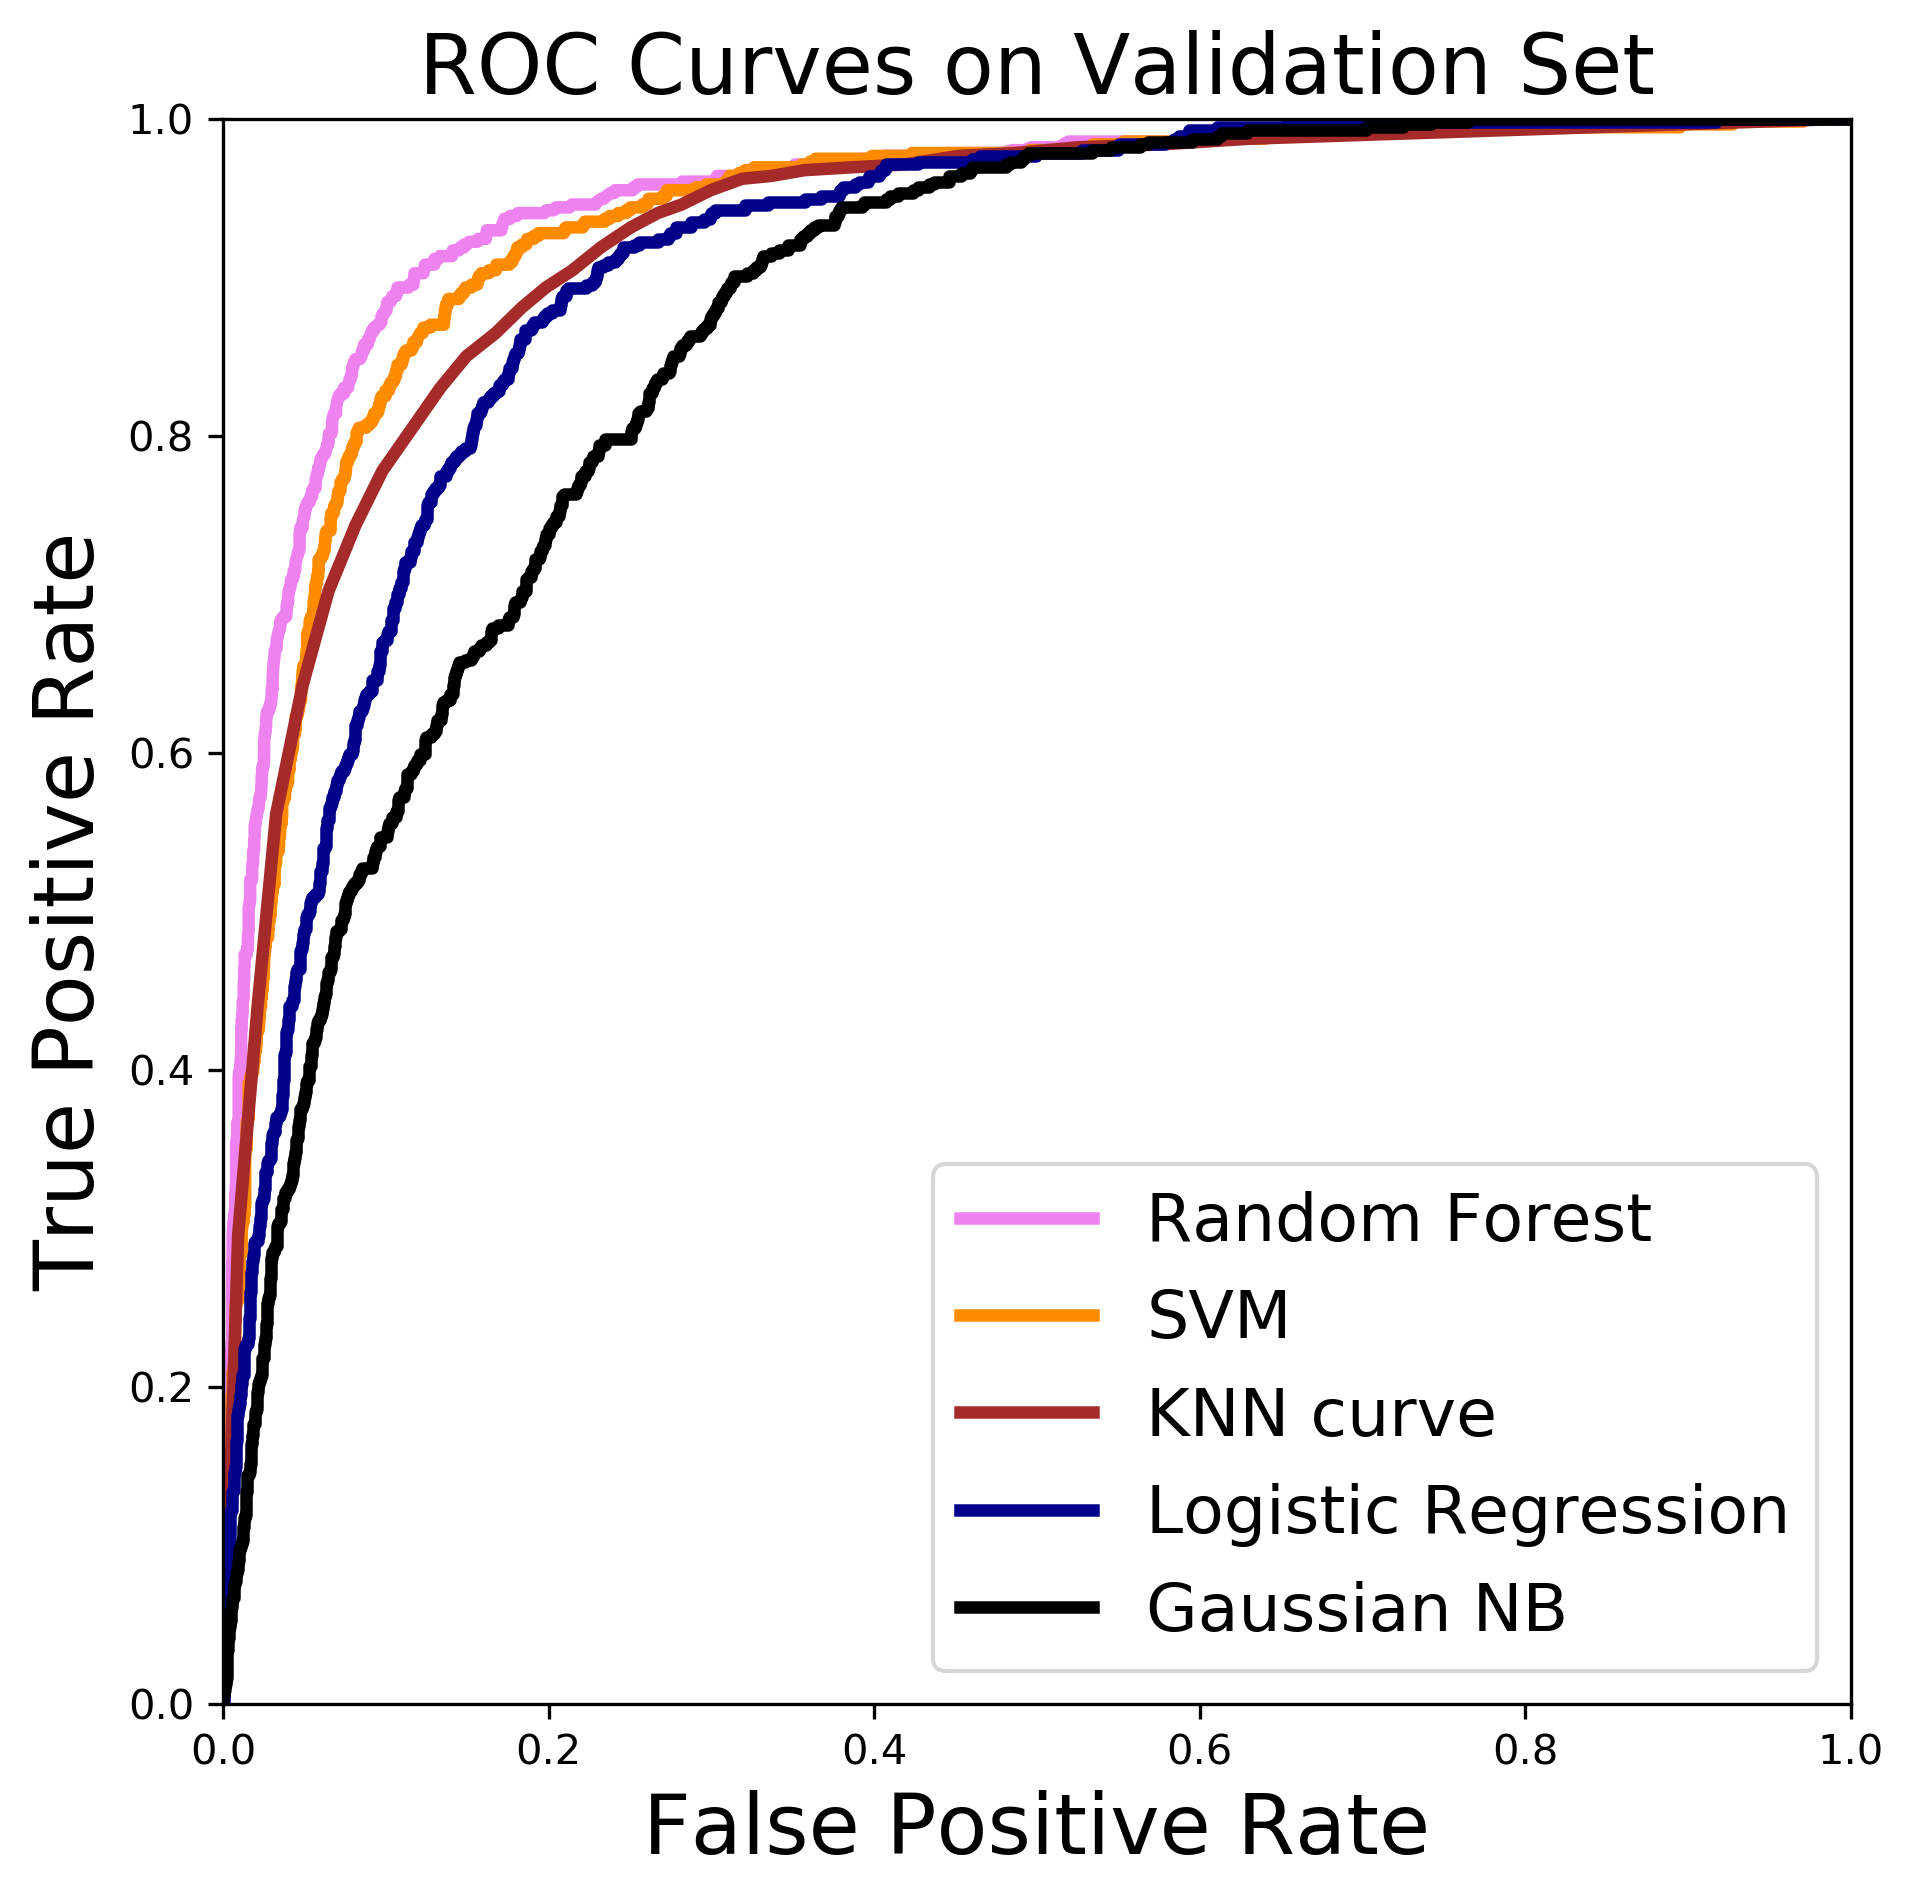

In [37]:
plt.figure(dpi=300,figsize=(7,7))

lw = 3

# plt.plot(xgBoost_fpr, xgBoost_tpr, color='green',
#          lw=lw, label='XGBoost (AUC = %0.2f)' % roc_auc_xgBoost)
plt.plot(rf_fpr, rf_tpr, color='violet',
         lw=lw, label='Random Forest')
plt.plot(svm_fpr, svm_tpr, color='darkorange',
         lw=lw, label='SVM')
plt.plot(knn_fpr, knn_tpr, color='brown',
         lw=lw, label='KNN curve')
# plt.plot(dt_fpr, dt_tpr, color='green',
#          lw=lw, label='Decision Tree')
plt.plot(lr_fpr, lr_tpr, color='darkblue',
         lw=lw, label='Logistic Regression')
plt.plot(gnb_fpr, gnb_tpr, color='black',
         lw=lw, label='Gaussian NB')



plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 20, )
plt.ylabel('True Positive Rate', fontsize = 20, )
plt.title('ROC Curves on Validation Set', fontsize = 20, )
plt.legend(loc="lower right", fontsize = 16)
#plt.savefig('roc_curves_all_ALL.png')
#plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

## Optimizing Threshold for Best Model (Random Forest)

In [38]:
def complete_confusion_matrix(y_actual,y_pred_before, y_pred_after):
    ''' Returns a confusion matrix using the predicted
    values from the model and actual data.'''
    
    plt.figure(figsize=(15,6),dpi=400)
    
    ### Confusion Matrix Before Threshold Adjustment
    
    plt.subplot(121)
    
    confusion1 = metrics.confusion_matrix(y_actual,y_pred_before)
    
    ax1 = sns.heatmap(confusion1, annot=True, cmap='Reds', cbar=False,
                   annot_kws={"size": 20}, fmt='g')
    
    # Creating labels for cells of matrix
    cmlabels = ['True Negatives', 'False Positives',
                 'False Negatives', 'True Positives']
    for i,t in enumerate(ax1.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])


    plt.xlabel('Predicted County Outcome',fontsize = 25)
    plt.ylabel('Actual County Outcome', fontsize = 25)
    plt.title('Before', fontsize = 30)
    labels = ['Low', 'High']
    ax1.set_xticklabels(labels, size = 25)
    ax1.set_yticklabels(labels, size = 25, va='center')
    
    ### Confusion Matrix After Threshold Adjustment
    
    plt.subplot(122)
    
    confusion2 = metrics.confusion_matrix(y_actual,y_pred_after)
    
    ax2 = sns.heatmap(confusion2, annot=True, cmap='Reds', cbar=False,
                   annot_kws={"size": 20}, fmt='g')
    
    # Creating labels for cells of matrix
    cmlabels = ['True Negatives', 'False Positives',
                 'False Negatives', 'True Positives']
    for i,t in enumerate(ax2.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])


    plt.xlabel('Predicted County Outcome',fontsize = 25)
    plt.ylabel('Actual County Outcome', fontsize = 25)
    plt.title('After', fontsize = 30)
    labels = ['Low', 'High']
    ax2.set_xticklabels(labels, size = 25)
    ax2.set_yticklabels(labels, size = 25, va='center')

    plt.show();

In [39]:
def recall_precision_before_and_after(y_val,y_pred_before, y_pred_after):
    '''Prints recall and precision for model 
    before and after threshold adjustment.'''
    
    print('BEFORE:')                                  
    print('Recall:',metrics.recall_score(y_val,y_pred_before))
    print('Precision:',metrics.precision_score(y_val,y_pred_before))

    print('AFTER:')                                  
    print('Recall:',metrics.recall_score(y_val,y_pred_after))
    print('Precision:',metrics.precision_score(y_val,y_pred_after))                                  

In [40]:
def threshold_adjustment_calculator(y_actual, y_pred_proba, fp_cost, fn_cost):
    '''Returns the best threshold of a model using the
    costs of false positives and false negatives.'''
    
    best_threshold = 0
    lowest_cost = 10000000
    
    
    # Looping through thresholds
    for threshold in np.linspace(0, 1, 101):
        y_pred = (y_pred_proba >= threshold)
    
        # Finding number of false positives and false negatives
        fp = sum((y_actual == 0) & (y_pred == 1))
        fn = sum((y_actual == 1) & (y_pred == 0))
    
        # Calulating weighted cost of this threshold
        total_cost = (fp*fp_cost + fn*fn_cost)
        
        # Redefining variables if threshold has lower cost 
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = threshold
            
    print('The best threshold is {}'.format(best_threshold))
    return best_threshold

In [41]:
def threshold_adjuster(y_pred_proba, threshold):
    '''Returns the predictions for target after threshold adjustment'''
    
    y_pred_after = []
    
    for prob in y_pred_proba:
        if prob >= threshold:
            y_pred_after.append(1)
        else:
            y_pred_after.append(0)
            
    return y_pred_after

In [42]:
# Best model's predicted classes before threshold adjustment
y_pred_class_before_thres_adj = rf_best_model.predict(X_val)

# Best model's predicted probabilities for classes before threshold adjustment
y_pred_proba = rf_best_model.predict_proba(X_val)[:,1]

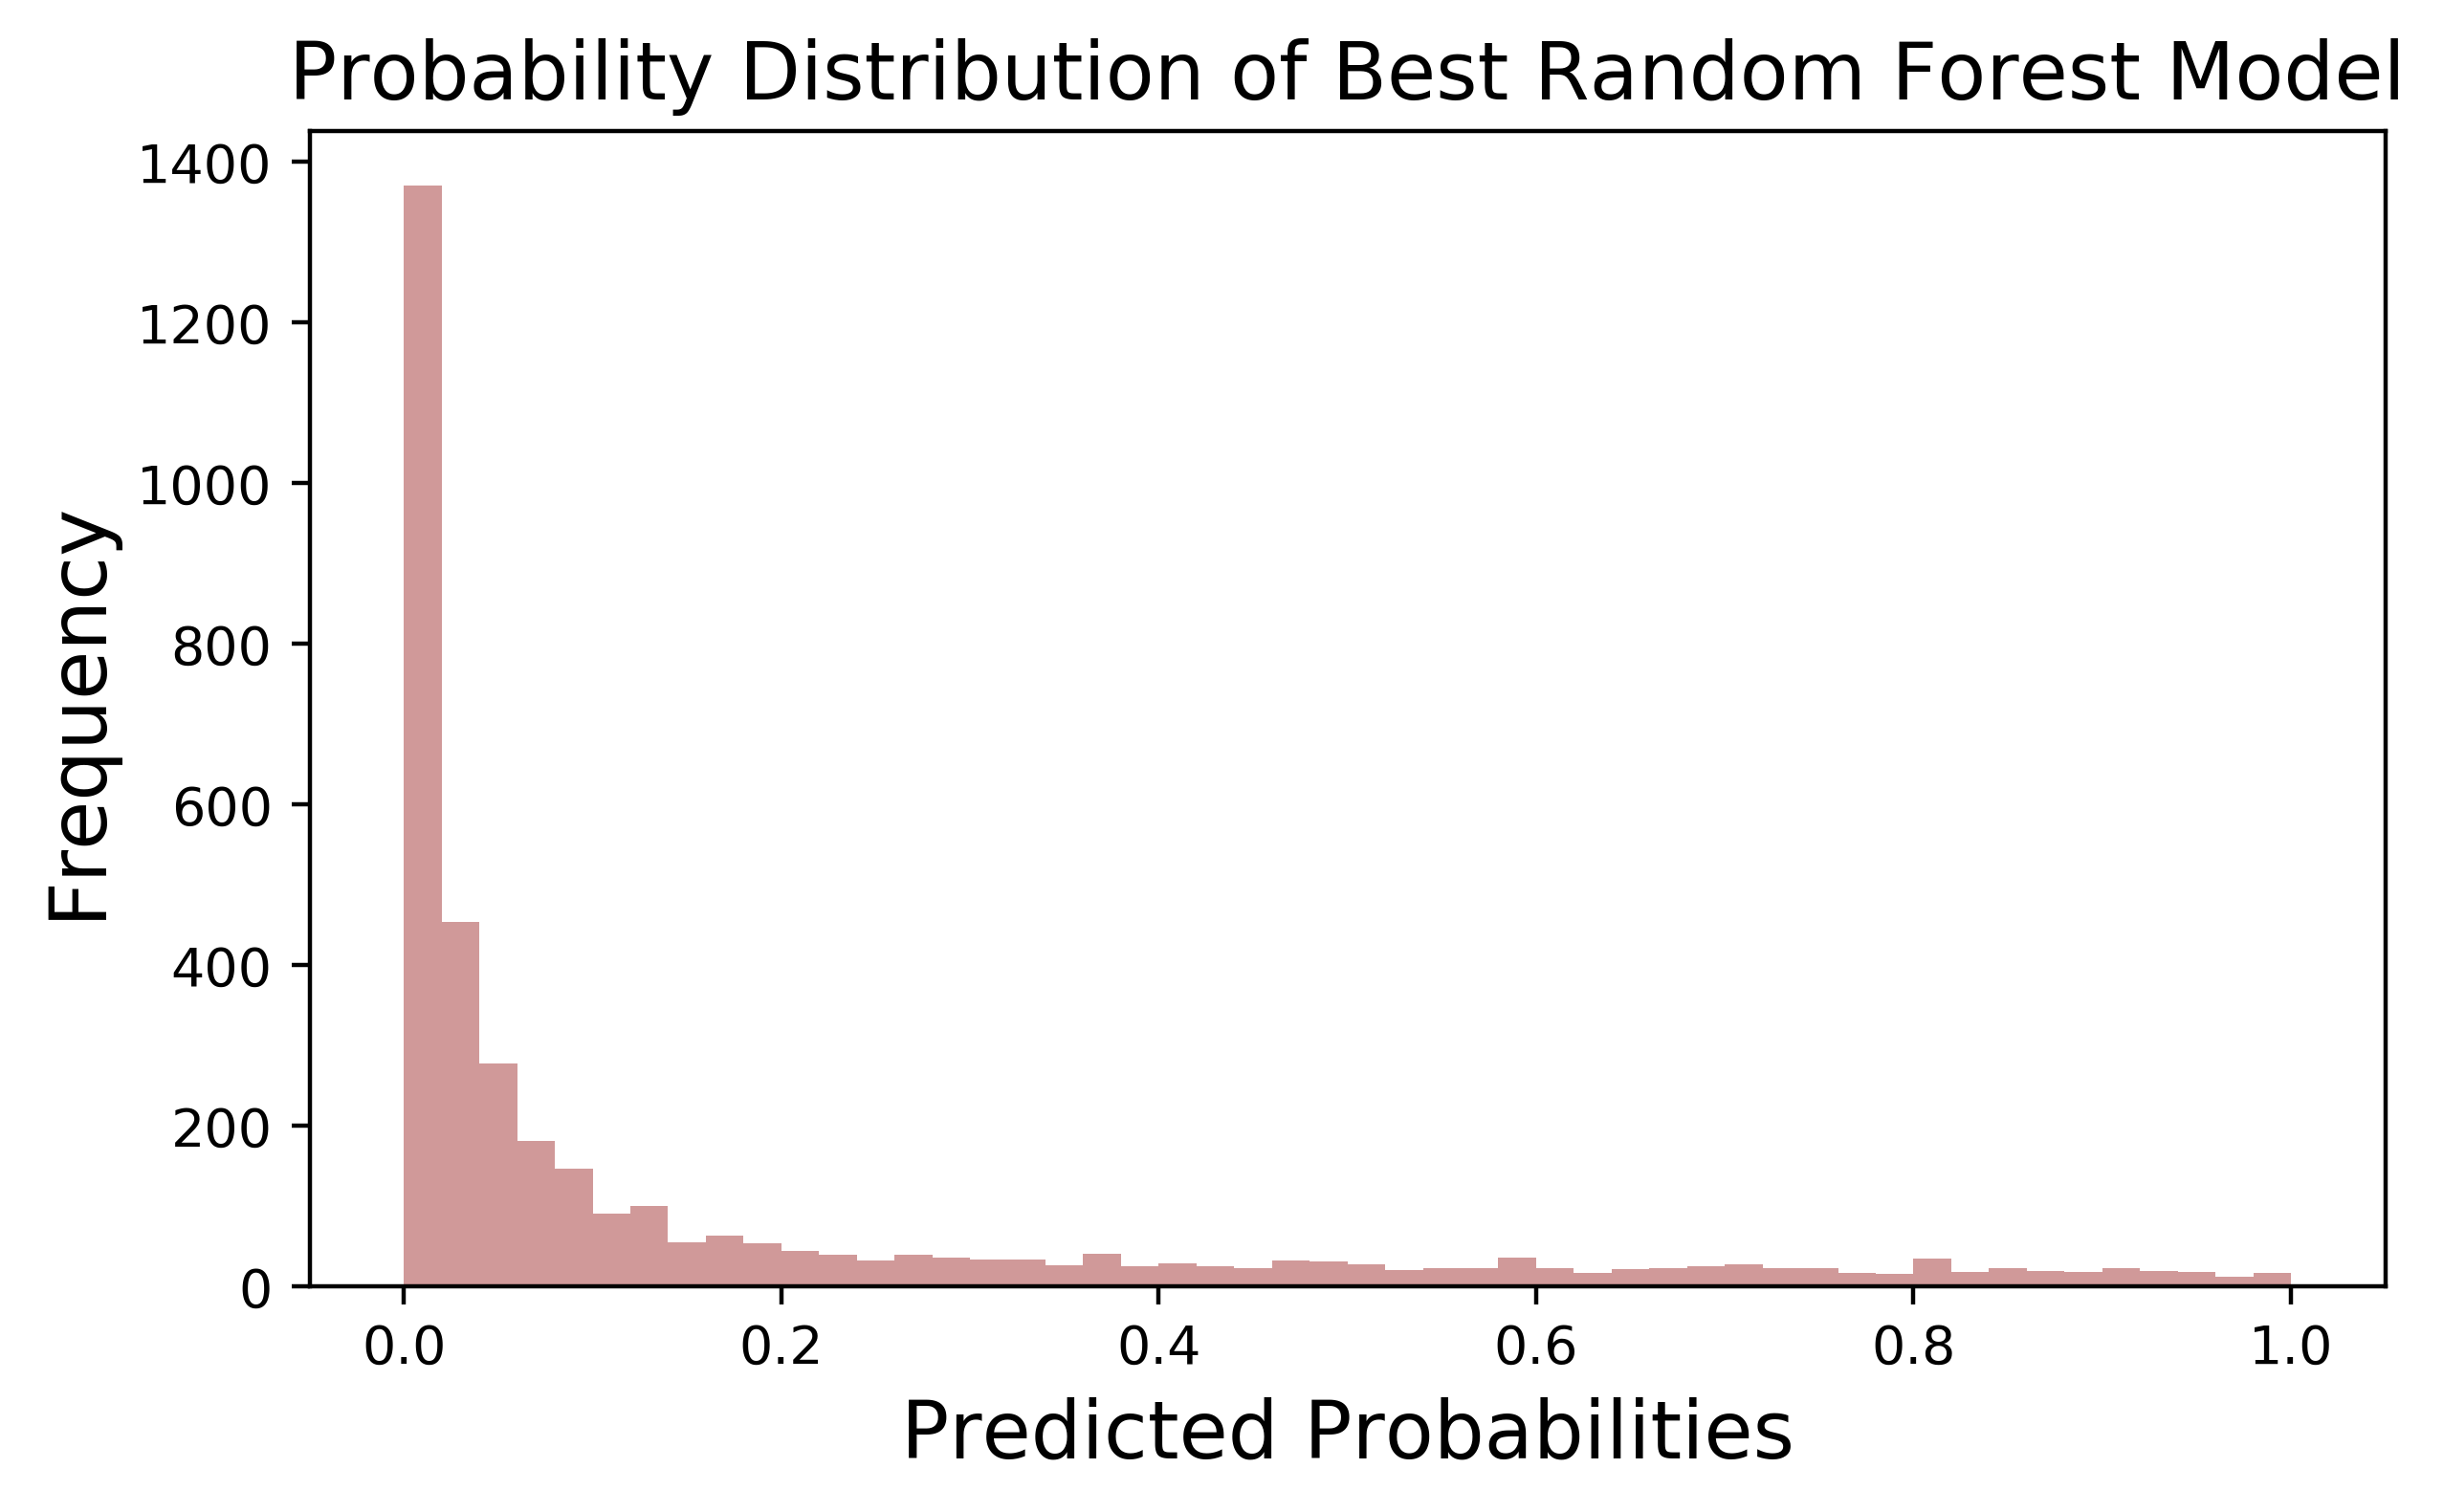

In [43]:
# Plotting Probability Distribution for Predicting Classes for Best Model
plt.figure(figsize=(7,4),dpi=400)

sns.distplot(y_pred_proba,color='darkred',bins=50,kde=False)

plt.title('Probability Distribution of Best Random Forest Model',fontsize = 15)
plt.xlabel('Predicted Probabilities',fontsize = 15)
plt.ylabel('Frequency', fontsize = 15);

In [44]:
# Finding best threshold for best model given costs
best_threshold = threshold_adjustment_calculator(y_val, y_pred_proba, fp_cost=1, fn_cost=11.7286)

# Finding new predicted classes based on best threshold
y_pred_class_after_thres_adj = threshold_adjuster(y_pred_proba, best_threshold)

The best threshold is 0.17


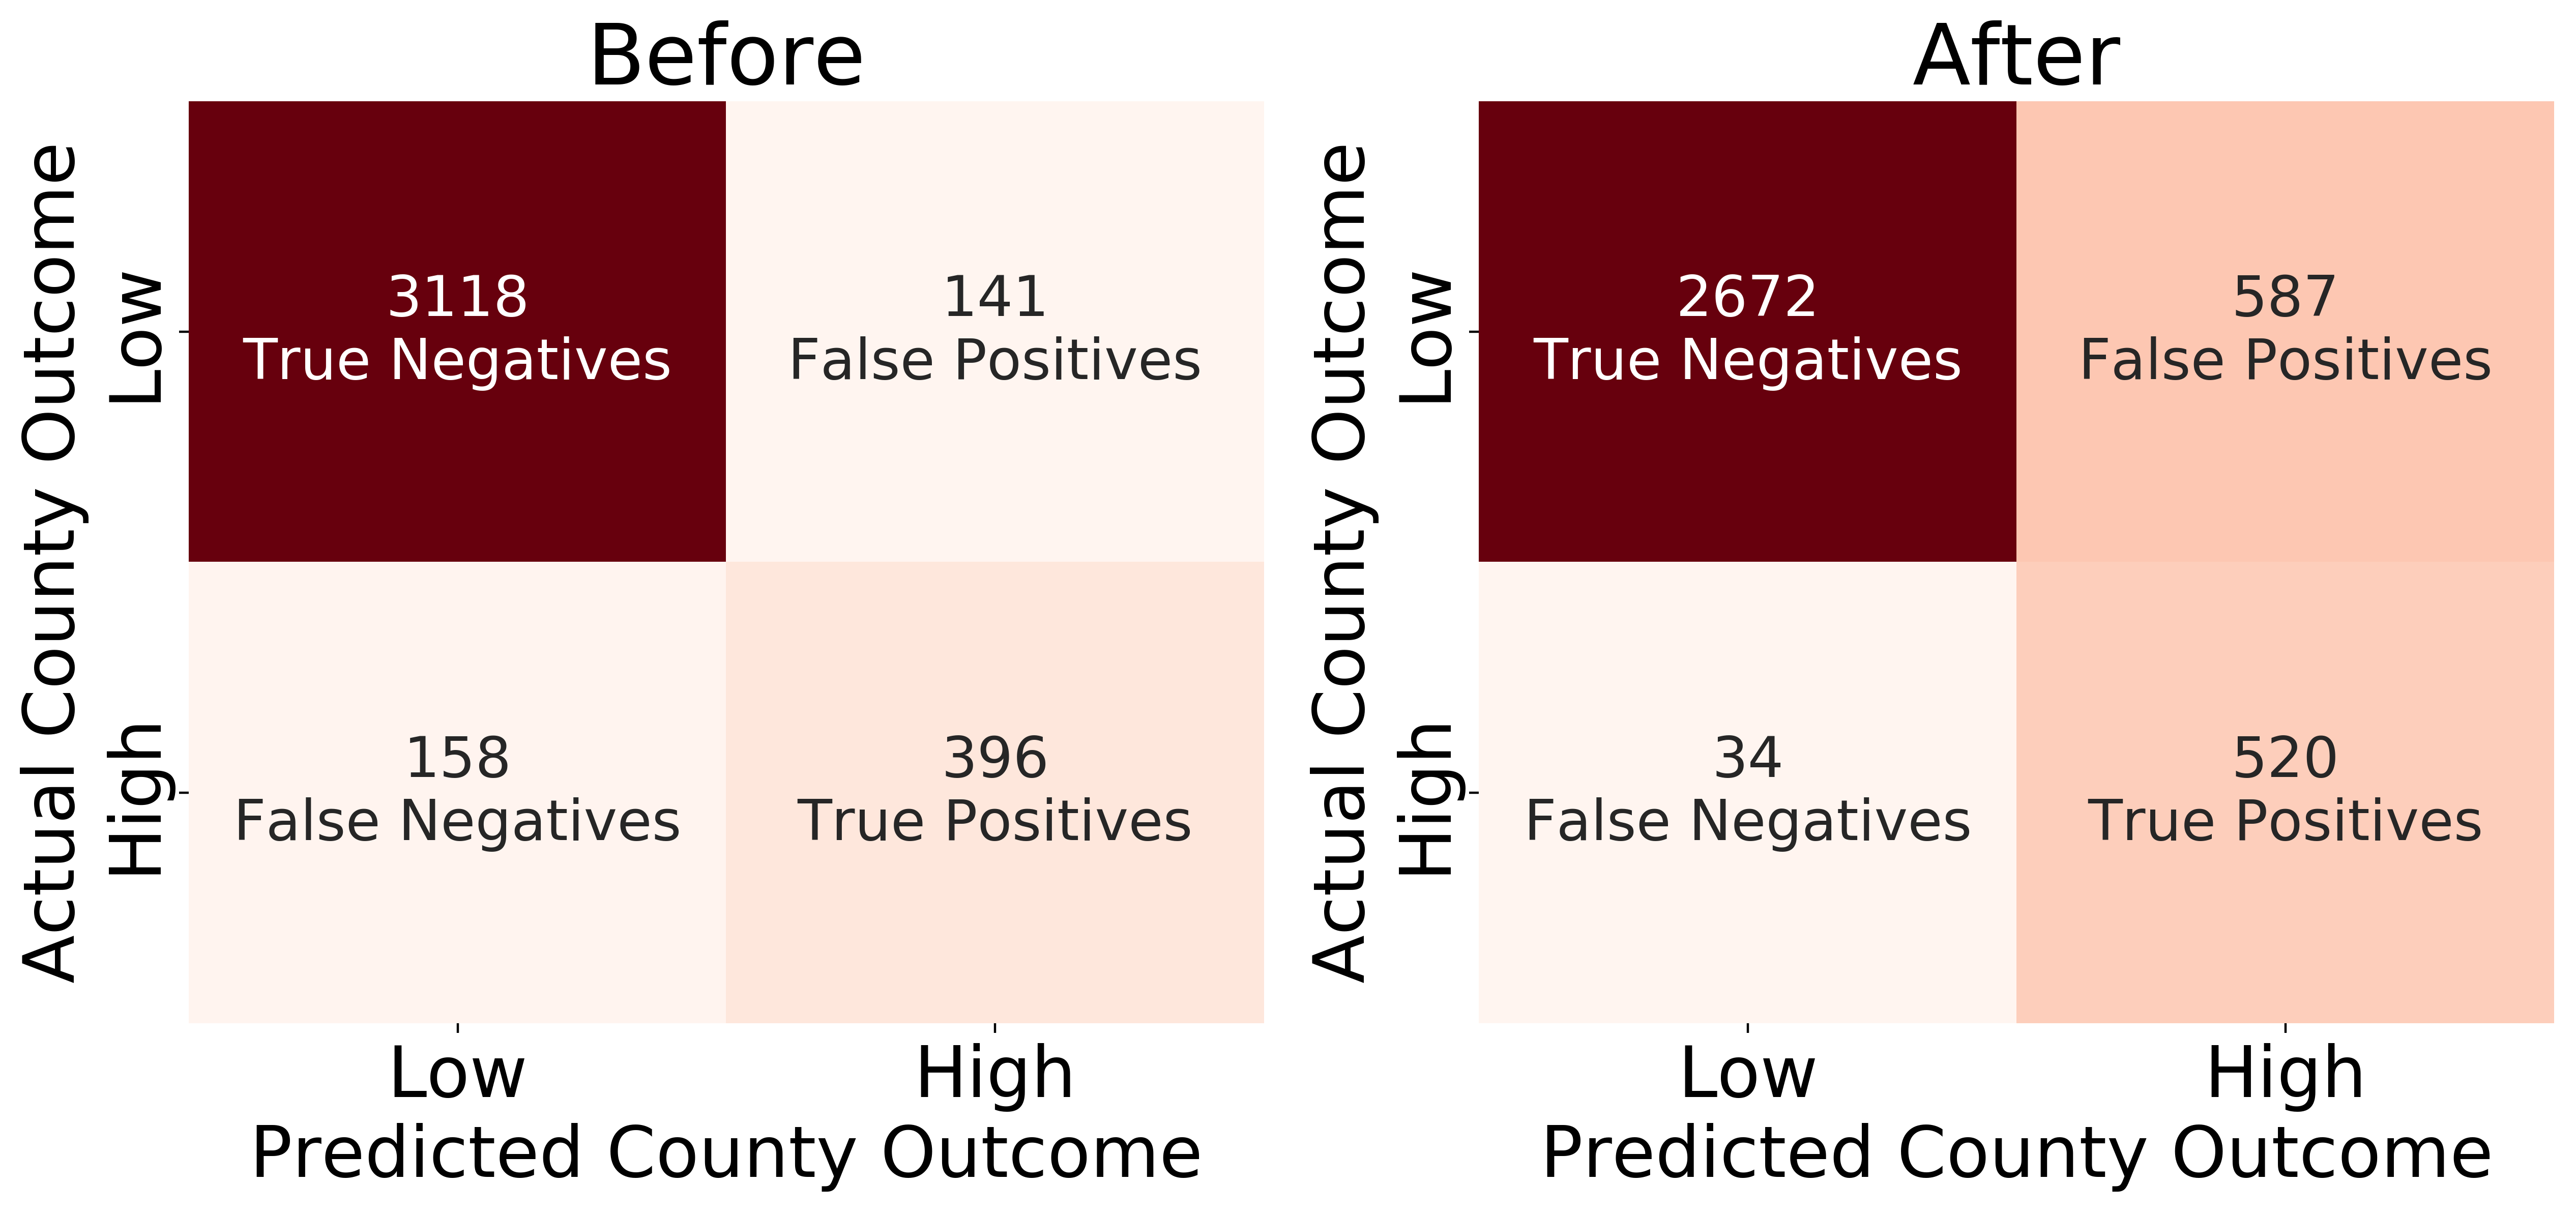

In [45]:
complete_confusion_matrix(y_val, y_pred_class_before_thres_adj,y_pred_class_after_thres_adj)

In [46]:
# Printing recall and precision before and after threshold adjustment
recall_precision_before_and_after(y_val,y_pred_class_before_thres_adj, y_pred_class_after_thres_adj)

BEFORE:
Recall: 0.7148014440433214
Precision: 0.7374301675977654
AFTER:
Recall: 0.9386281588447654
Precision: 0.46973803071364045


## Feature Importance

In [47]:
# Defining variables for feature importance visualization
feature_importances = rf_best_model.best_estimator_.steps[2][1].feature_importances_
top_feature_indices =  pd.Series(feature_importances).nlargest(10).index
top_feature_values = pd.Series(feature_importances).nlargest(10).values
top_feature_names = [X.columns.values[i] for i in top_feature_indices]

In [48]:
# List of Top 10 Features rwith their corresponding values
for x,y in zip(top_feature_names,top_feature_values):
    print(x,y)

max_snowfall_year 0.08091950714619078
ELEVATION 0.08026113036392518
total_snowfall_year 0.06890727131524535
max_temp_num_days_over_70 0.05958958421559672
max_snow_depth_year 0.05762039215492397
max_temp_num_days_over_90 0.05671802056431515
precip_num_days_over_0.01 0.05345462939427342
avg_daily_max_temp 0.045389242838675875
total_precip_year 0.04343388755377962
snowfall_num_days_over_1 0.042853844715640035


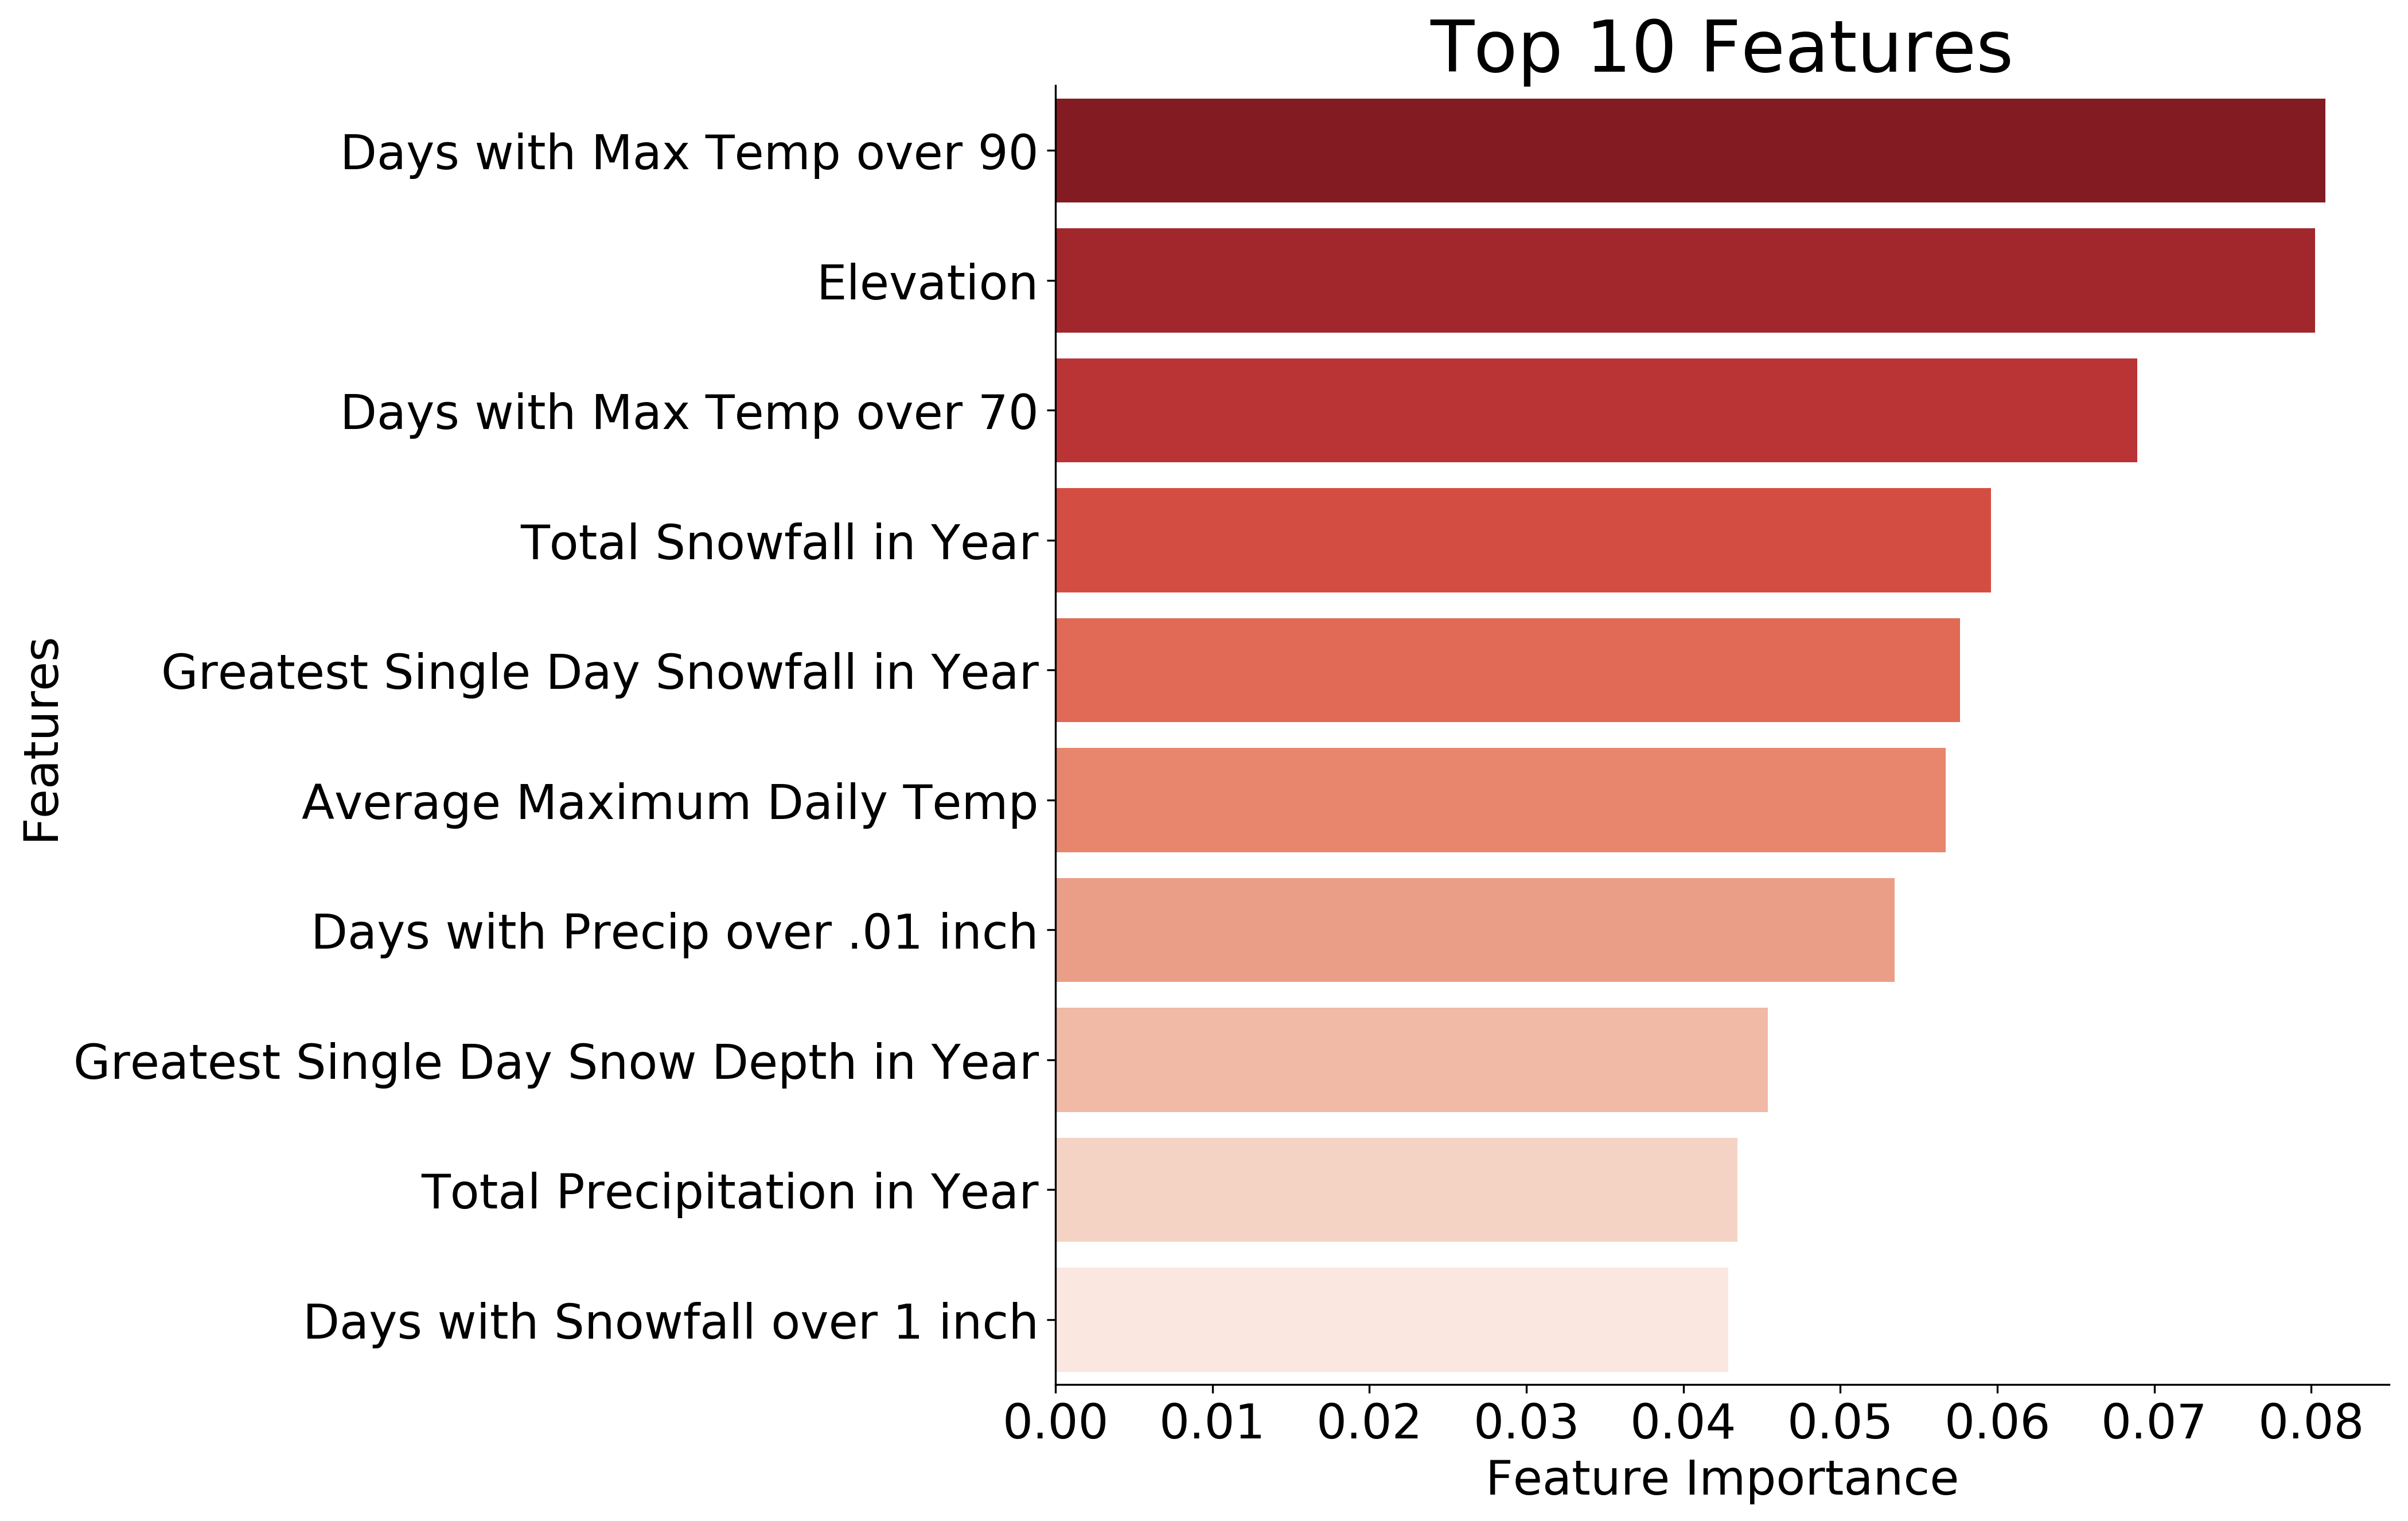

In [49]:
# Plotting Feature Importance
plt.figure(dpi=300,figsize=(10,10))

y_axis_labels = ['Days with Max Temp over 90',
 'Elevation',
 'Days with Max Temp over 70',
 'Total Snowfall in Year',
 'Greatest Single Day Snowfall in Year',
 'Average Maximum Daily Temp',
 'Days with Precip over .01 inch',
 'Greatest Single Day Snow Depth in Year',
 'Total Precipitation in Year',
 'Days with Snowfall over 1 inch']
 
sns.barplot(top_feature_values,y_axis_labels, orient='h',palette='Reds_r')

plt.title('Top 10 Features', size= 30)
plt.xlabel('Feature Importance', size= 20)
plt.ylabel('Features', size= 20)
plt.xticks(size= 20,)
plt.yticks(size= 20,)

sns.despine()